#### Summary:
Here I will use a cleaned up copy of the final single sample processing notebook (third version of the sample specific cell QC filtering methods) to experiment with some proposed changes for v2 of the multiome processing pipeline. Not all changes I want to make are relevant to running in a jupyter notebook but this should be helpful for working through the ones that are. 

### Proposed changes:
- Figure out how to printout the SoupX estimated background contamination from the sc object
- Save raw RNA data as another assay in adata (instead of overwriting)
- Change the marker gene list for dot plots to read from an input file

### Found a small error in this notebook:
We read in the lfm from the data folder, but I believe we now output that to the outputs folder. So it was reading in an outdated file that had a few BC differences (likely due to the later addition of the step to remove multiplets?). I think this may not be an issue in the scripts already, but make sure!

In [1]:
#always run this first!!
#essential reticulate functions that allow us to use python packages in R
#you'll need a conda env with 'reticulate', leidenalg' and 'pandas' installed to do this
#then route reticulate to the python installed in that conda env with the below functions
#change the path to whichever conda env you installed reticulate in

Sys.setenv(RETICULATE_PYTHON="/home/hmummey/.conda/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/hmummey/.conda/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/hmummey/.conda/envs/reticulate")
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(leidenalg)

In [2]:
#is you get messages that any of these packages aren't installed
#go ahead and locally install them yourself using install.packages()

suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(harmony))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
warnLevel <- getOption('warn')
options(warn = -1)

# Read in data

In [3]:
sample <- 'R221'
wd <- sprintf('/nfs/lab/projects/multiomic_islet/data/multiomics/cellranger/deep-shallow/%s/outs/', sample)
inputdata.10x <- Read10X_h5(file.path(wd, 'raw_feature_bc_matrix.h5'))

rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$`Peaks`
adata <- CreateSeuratObject(counts=rna_counts)
adata[['percent.mt']] <- PercentageFeatureSet(adata, pattern = '^MT-')
print(paste(length(colnames(adata[["RNA"]])),"total BCs"))
adata #returns summary of the Seurat object and active assay

Genome matrix has multiple modalities, returning a list of matrices for this genome



[1] "670706 total BCs"


An object of class Seurat 
36601 features across 670706 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

# Filter by RNA and ATAC Metrics
### Filter by parameter: RNA nFeatures > 500

In [4]:
adata_sub <- subset(
  x = adata,
  subset = nFeature_RNA >= 500
)
print(paste(length(colnames(adata_sub[["RNA"]])),"total BCs after RNA threshold"))
#adata_sub

[1] "7820 total BCs after RNA threshold"


### Add QC data from per_barcode_metrics.csv

In [5]:
qc <- read.table(file.path(wd, 'per_barcode_metrics.csv'), sep=',', header=TRUE, stringsAsFactors=1)
qc <- as.data.frame(qc)
rownames(qc) <- qc$gex_barcode
qc <- qc[Cells(adata_sub), 1:length(colnames(qc))]
adata_sub <- AddMetaData(adata_sub, qc)
gc()

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells  11314269  604.3  17230688   920.3  17230688  920.3
Vcells 154536831 1179.1 332779377  2539.0 332103400 2533.8

### Filter Seurat Object using ATAC frag metric, atac_raw_reads > 1000 per cell

In [6]:
adata_sub_atac <- subset(
  x = adata_sub,
  subset = atac_fragments >= 1000 
)
print(paste(length(colnames(adata_sub_atac[["RNA"]])),"total BCs after ATAC threshold"))
#adata_sub_atac

[1] "7158 total BCs after ATAC threshold"


### Remove multiplets

In [7]:
adata_sub_multiplet <- subset(
  x = adata_sub_atac,
  subset = excluded_reason != 1 
)
print(paste(length(colnames(adata_sub_multiplet[["RNA"]])),"total BCs after multiplet removal"))
#adata_sub_multiplet

[1] "7127 total BCs after multiplet removal"


### Add the fragment/ATAC data for the barcodes that have passed both of these filters and create a ChromatinAssay object (used to add ATAC data to a Seurat object)

In [8]:
atac_counts <- atac_counts[,colnames(adata_sub_multiplet)]
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(':', '-'))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

frag.file <- file.path(wd, 'atac_fragments.tsv.gz')
suppressWarnings(chrom_assay <- CreateChromatinAssay(counts=atac_counts, sep=c(':', '-'), genome='hg38', fragments=frag.file, min.cells=0, min.features=0, annotation=annotations))
adata_sub_multiplet[['ATAC']] <- chrom_assay

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [9]:
adata_sub_multiplet

An object of class Seurat 
149392 features across 7127 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ATAC

### Compute bulk metrics

In [10]:
adata <- adata_sub_multiplet
print(paste("ATAC median high-quality fragments per cell (atac_fragments):",median(adata[[]][,'atac_fragments'])))
DefaultAssay(adata) <- 'ATAC'
suppressMessages(adata <- TSSEnrichment(adata))
print(paste("ATAC median TSSe:",median(adata[[]][,'TSS.enrichment'])))
print(paste("RNA median genes per cell:",median(adata[[]][,'nFeature_RNA'])))

[1] "ATAC median high-quality fragments per cell (atac_fragments): 13753"
[1] "ATAC median TSSe: 3.59314819599952"
[1] "RNA median genes per cell: 1624"


# Cluster Filtered Object

In [11]:
adata

An object of class Seurat 
149392 features across 7127 samples within 2 assays 
Active assay: ATAC (112791 features, 0 variable features)
 1 other assay present: RNA

In [12]:
# RNA analysis
DefaultAssay(adata) <- 'RNA'
adata <- SCTransform(adata, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')

# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata) <- 'ATAC'
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0')
adata <- RunSVD(adata)
adata <- RunUMAP(adata, reduction='lsi', dims=2:50, reduction.name='umap.atac', reduction.key='atacUMAP_')

PC_ 1 
Positive:  CD44, LINC00342, TXNRD1, ANKRD36C, SLC7A11, CHRM3, NIBAN1, NEAT1, ZNF704, SLC38A1 
	   PTPRK, CEMIP2, PARD3, USP53, RAB27B, MYO1E, ADAMTS9, ABTB2, SAT1, EPS8 
	   MYO6, TANC1, TJP2, GCLC, SHANK2, RB1CC1, LARGE1, SVIL, SMAD3, FAM160A1 
Negative:  RGS7, PAM, INS, GPC6, HS6ST3, GCG, SPOCK3, CADM1, CNTNAP5, TTR 
	   KCNMA1, CADPS, FSTL5, PDE4D, TMEM132D, SEMA3E, MMP16, SLC35F4, DST, ADAMTS18 
	   ZNF385D, RIMS2, NCAM1, AGBL4, MEIS2, RGS17, LRRTM4, CACNA1C, EML5, ASAP1 
PC_ 2 
Positive:  PAM, RGS7, GPC6, HS6ST3, SPOCK3, DTNA, FSTL5, SLC7A11, CHRM3, CNTNAP5 
	   PLCB1, MAML3, NEAT1, MAP2, FNDC3B, ADAMTS18, SEMA3E, CADPS, NIBAN1, CADM1 
	   MMP16, LINC00342, UBE2E2, ANKRD36C, ALCAM, SDK1, LRRTM4, SAMD5, SLC35F4, KCNMA1 
Negative:  MT-CO2, MT-CO3, MT-ATP6, MT-ND1, MT-CYB, MT-ND3, MT-ND2, DAB1, MT-CO1, SGO1-AS1 
	   MT-ND4, DLG2, PDE4C, IL12RB1, EGLN3, DNAH12, SCAI, PECAM1, MT-ND5, DNAH2 
	   AC023509.6, AC092944.1, LINC02245, LEKR1, ZNF556, SCN11A, AP000446.1, HCG17, OOEP, NR

In [13]:
#multimodal analysis steps (See Seurat weighted nearest neighbors paper to learn more!)
adata <- FindMultiModalNeighbors(adata, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata <- FindClusters(adata, graph.name='wsnn', algorithm=4, resolution = .5, verbose=FALSE)

adata$log_nCount_ATAC = log(adata$nCount_ATAC)
adata$log_nCount_SCT = log(adata$nCount_SCT)
adata$log_nFeature_ATAC = log(adata$nFeature_ATAC)
adata$log_nFeature_SCT = log(adata$nFeature_SCT)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

14:44:21 UMAP embedding parameters a = 0.9922 b = 1.112

14:44:23 Commencing smooth kNN distance calibration using 1 thread

14:44:26 Initializing from normalized Laplacian + noise

14:44:27 Commencing optimization for 500 epochs, with 219408 positive edges

14:44:36 Optimization finished



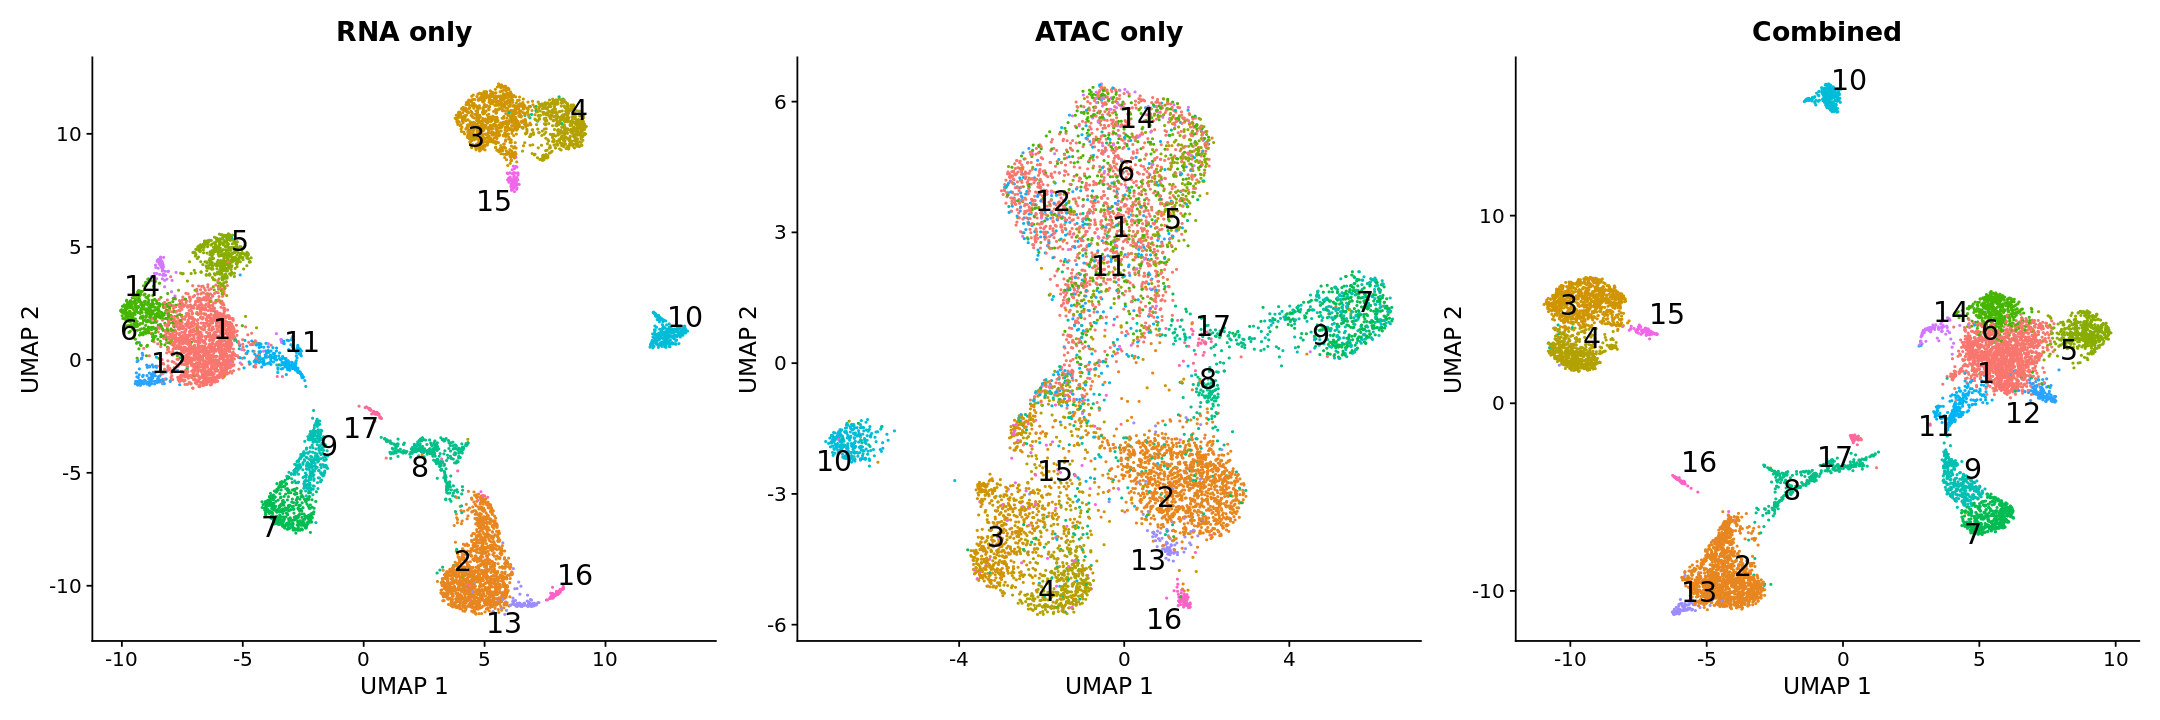

In [14]:
#plot UMAPs of single and combined modalities
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1')+ ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

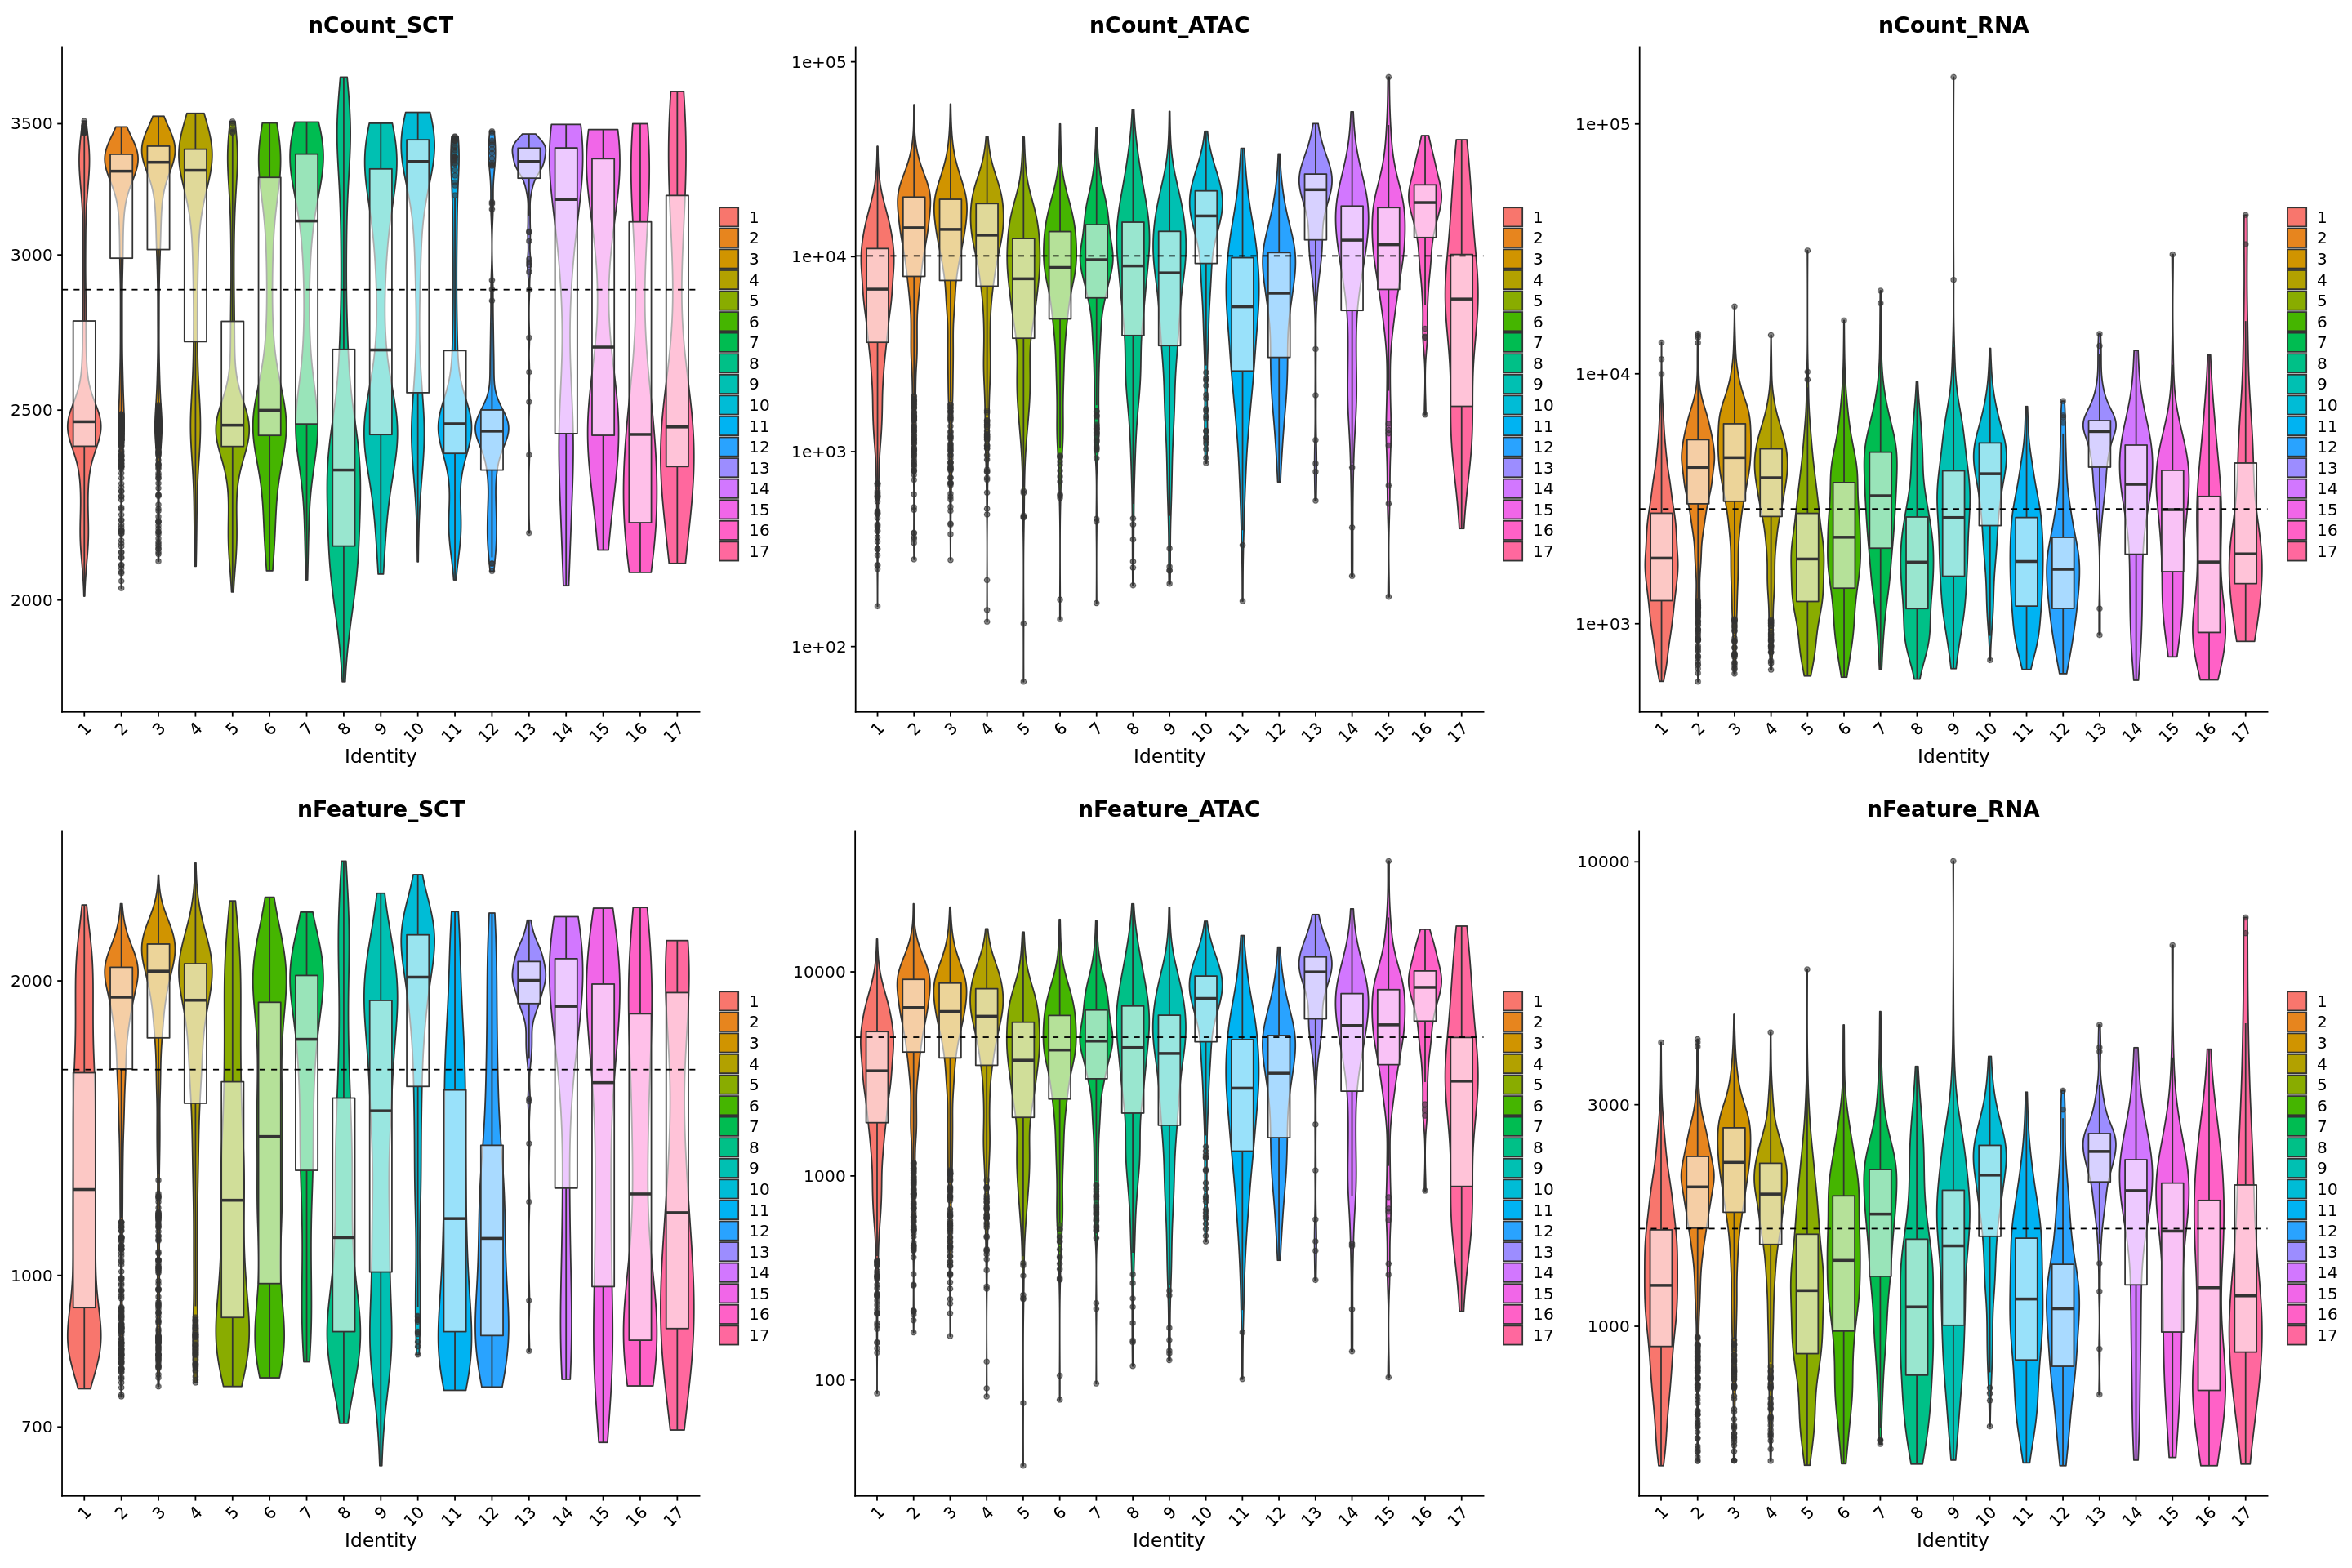

In [15]:
#plot ATAC, RNA, and SCT(normalized RNA) metrics by cluster
options(repr.plot.width=24, repr.plot.height=16)
p1 <- VlnPlot(adata, features='nCount_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2)
p2 <- VlnPlot(adata, features='nFeature_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2)
p3 <- VlnPlot(adata, features='nCount_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_ATAC), linetype='dashed', lw=2)
p4 <- VlnPlot(adata, features='nFeature_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_ATAC), linetype='dashed', lw=2)
p5 <- VlnPlot(adata, features='nCount_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2)
p6 <- VlnPlot(adata, features='nFeature_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2)
# p1 / p2 
# p3 / p4 
# p5 / p6

figure <- ggarrange(p1, p3, p5, p2, p4, p6, ncol = 3, nrow = 2)
figure

[1] "INS"    "IAPP"   "HADH"   "GCG"    "FAP"    "TTR"    "SST"    "PPY"   
 [9] "CFTR"   "REG1A"  "CTRB2"  "PRSS1"  "PDGFRB" "COL6A1" "SPARC"  "RGS5"  
[17] "FABP4"  "GJC1"   "PLVAP"  "ESAM"   "VWF"    "CDH19"  "KIT"    "CD69"

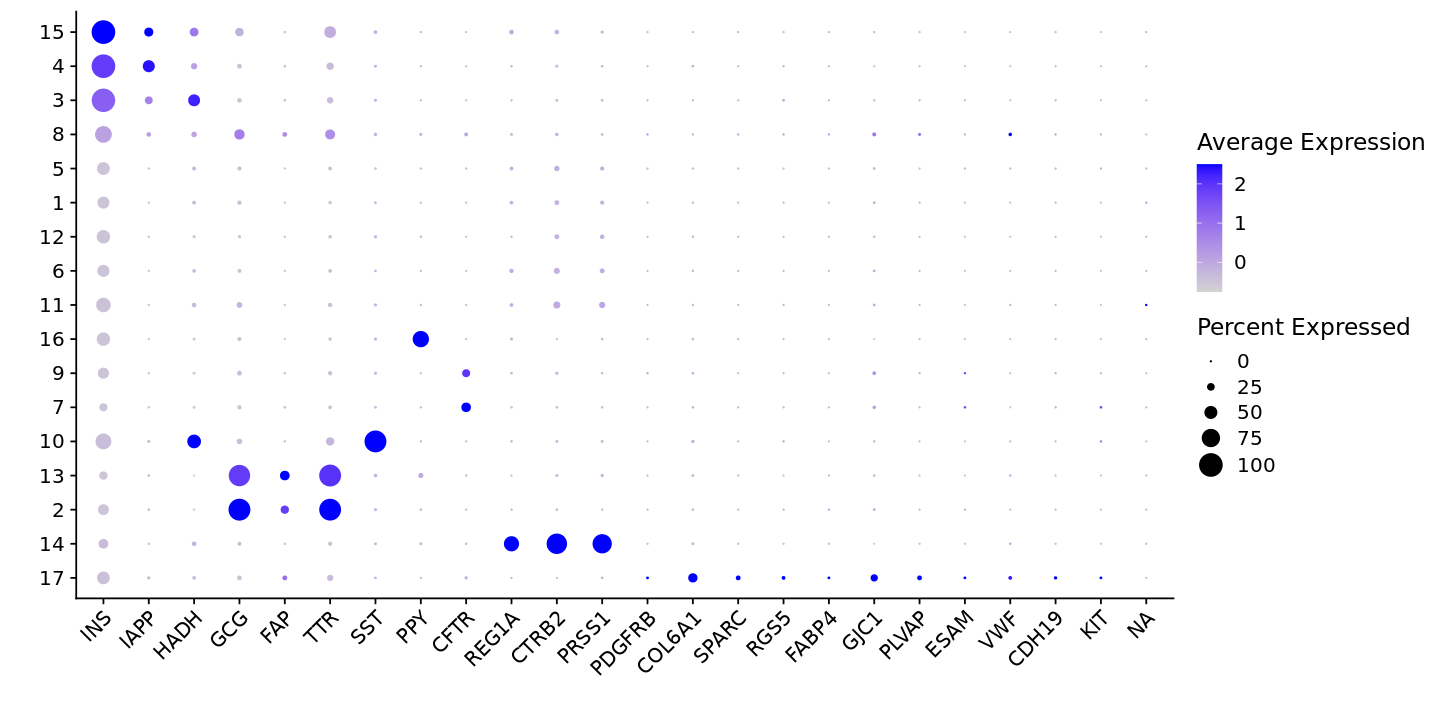

In [19]:
#read in marker genes list from a file
markers.fp1 <- '/nfs/lab/projects/multiomic_islet/references/islet_markers.txt'
marker.genes.long <- scan(markers.fp1,what="",sep="\n")
marker.genes.long

options(repr.plot.width=12, repr.plot.height=6)
p1 <- DotPlot(adata, assay='SCT', features=marker.genes.long, cluster.idents=TRUE) 
p1 <- p1 + theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
p1

# Remove Background Noise from RNA Counts with SoupX

### Visualize UMIs/BC Distribution
With these plots you can get a good idea of how many good quality BCs are in the sample and also visualize how many empty droplets you likely have (what SoupX uses).

In [24]:
#read in the cellranger output per_barcode_metrics.csv file
bc_summary_fp = sprintf("/nfs/lab/projects/multiomic_islet/data/multiomics/cellranger/deep-shallow/%s/outs/per_barcode_metrics.csv",sample)
bc_summary = read.table(bc_summary_fp, sep=',', header=1)
bc_summary["new_gex_umis_count"] = bc_summary["gex_exonic_umis"] + bc_summary["gex_intronic_umis"]
head(bc_summary)

barcode            gex_barcode        atac_barcode       is_cell
1 AAACAGCCAAACAACA-1 AAACAGCCAAACAACA-1 ACAGCGGGTGTGTTAC-1 0      
2 AAACAGCCAAACATAG-1 AAACAGCCAAACATAG-1 ACAGCGGGTTGTTCTT-1 0      
3 AAACAGCCAAACCCTA-1 AAACAGCCAAACCCTA-1 ACAGCGGGTAACAGGC-1 0      
4 AAACAGCCAAACCTAT-1 AAACAGCCAAACCTAT-1 ACAGCGGGTGCGCGAA-1 0      
5 AAACAGCCAAACGCGA-1 AAACAGCCAAACGCGA-1 ACAGCGGGTCATGGTT-1 0      
6 AAACAGCCAAACGGGC-1 AAACAGCCAAACGGGC-1 ACAGCGGGTAGGTGAC-1 0      
  excluded_reason gex_raw_reads gex_mapped_reads gex_conf_intergenic_reads
1 0                4             3               2                        
2 0                2             2               0                        
3 2                1             1               0                        
4 2                6             5               0                        
5 0               46            43               8                        
6 0                2             2               0                        
  gex_conf_exonic_reads gex_conf_intronic_reads ⋯ atac_unmapped_reads
1 0                      1                      ⋯ 0                  
2 1                      1                      ⋯ 1                  
3 0                      1                      ⋯ 0                  
4 0                      5                      ⋯ 0                  
5 8                     24                      ⋯ 3                  
6 0                      2                      ⋯ 0                  
  atac_lowmapq atac_dup_reads atac_chimeric_reads atac_mitochondrial_reads
1 0             0             0                   0                       
2 0             4             0                   0                       
3 0             2             0                   0                       
4 0             0             0                   0                       
5 5            14             0                   6                       
6 0             0             0                   0                       
  atac_fragments atac_TSS_fragments atac_peak_region_fragments
1  0              0                  0                        
2  2              2                  1                        
3  2              2                  0                        
4  1              0                  0                        
5 73             13                 21                        
6  0              0                  0                        
  atac_peak_region_cutsites new_gex_umis_count
1  0                         0                
2  2                         2                
3  0                         0                
4  0                         2                
5 40                        16                
6  0                         1

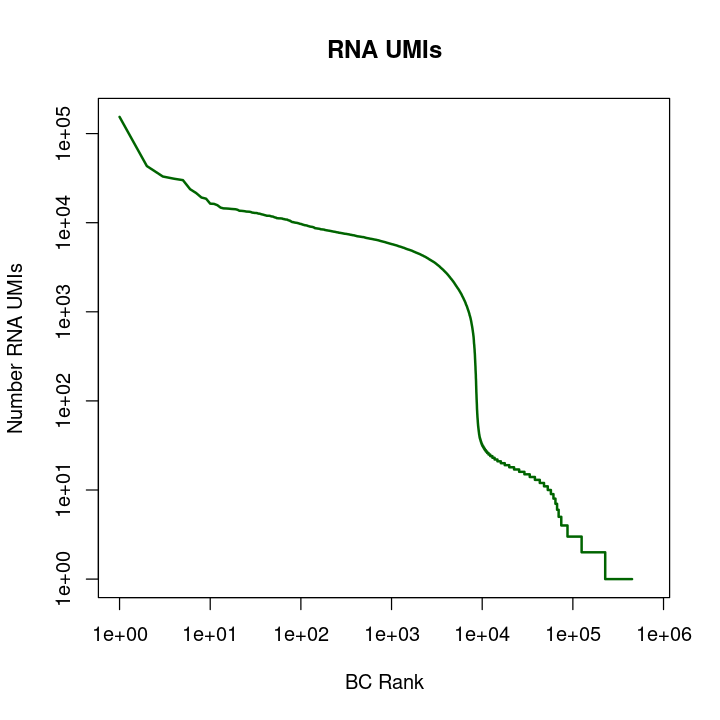

In [25]:
#plot RNA UMIs (gex_exonic_umis+gex_intronic_umis) per each BC
options(repr.plot.width=6,repr.plot.height=6)
bc_summary <- bc_summary[order(bc_summary$new_gex_umis_count, decreasing=TRUE),]
plot(bc_summary$new_gex_umis_count, log='xy', type='l', main="RNA UMIs", 
     xlab="BC Rank", ylab="Number RNA UMIs", col='dark green', lwd=2)

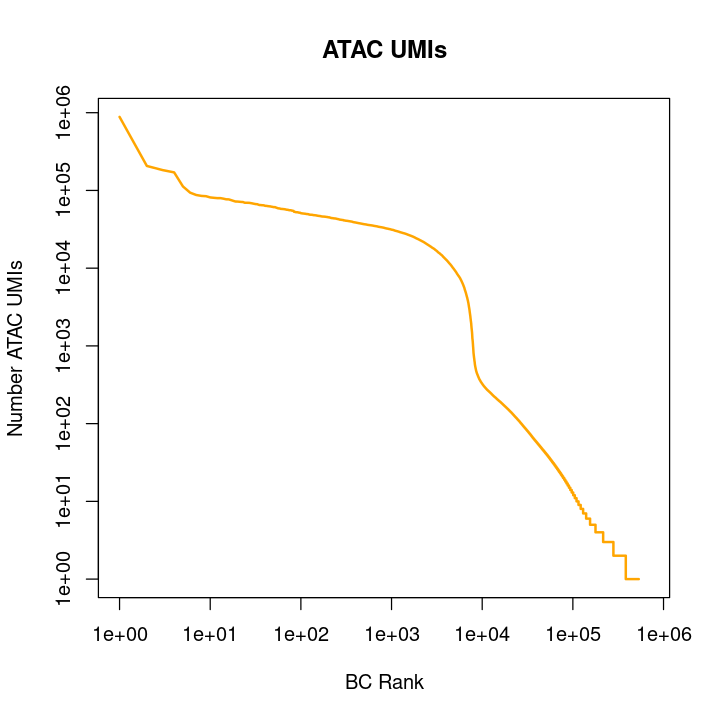

In [26]:
#plot ATAC UMIs (atac_fragments) per each BC
bc_summary <- bc_summary[order(bc_summary$atac_fragments, decreasing=TRUE),]
plot(bc_summary$atac_fragments, log='xy', type='l', main="ATAC UMIs", 
     xlab="BC Rank", ylab="Number ATAC UMIs", col='orange', lwd=2)

### Read in Data and Prepare Metadata

In [20]:
library(knitr)
opts_chunk$set(tidy=TRUE)
library(SoupX)

In [21]:
adata

An object of class Seurat 
171867 features across 7127 samples within 3 assays 
Active assay: ATAC (112791 features, 112791 variable features)
 2 other assays present: RNA, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

In [22]:
#get the raw and filtered (by us) RNA counts matrices
#Read in RNA assay counts from our filtered seurat object

DefaultAssay(adata) <- 'RNA'
toc = GetAssayData(object = adata, slot = "counts")

#Read in raw RNA counts from CellRanger outputs
tod = Seurat::Read10X_h5(file.path(wd, 'raw_feature_bc_matrix.h5'))$`Gene Expression`

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [23]:
#pull out the required metadata from the clustered filtered adata object
#we need the UMAP coordinates (RD1 and RD2) and the cluster assignments at minimum
#you can also add a cluster annotations col, but that's just for plotting aesthetics 
#although it is currently required for a few plots, so I just use the cluster #

metadata <- (cbind(as.data.frame(adata[["umap.wnn"]]@cell.embeddings),
                   as.data.frame(Idents(adata)),
                   as.data.frame(Idents(adata))))
colnames(metadata) <- c("RD1","RD2","Cluster","Annotation")
dim(metadata)
head(metadata)

[1] 7127    4

RD1        RD2       Cluster Annotation
AAACAGCCACCTGCCT-1 -3.3766205 -9.939690 2       2         
AAACAGCCACGGTTTA-1  6.4109314  2.349298 1       1         
AAACAGCCATTGCAGC-1 -4.6571676 -9.862385 2       2         
AAACATGCAACACCTA-1  4.7298556  1.745695 1       1         
AAACATGCAACCCTCC-1 -9.1658170  2.544510 4       4         
AAACATGCAATAGCAA-1  0.4578299 -1.772267 17      17

In [24]:
#check that the metadata BCs match the toc matrix barcodes (should all be TRUE)
metadatanames <- row.names(metadata)
tocnames <- colnames(toc)
table(metadatanames %in% tocnames)
table(tocnames %in% metadatanames)


TRUE 
7127 


TRUE 
7127 

In [25]:
#doublecheck that the toc and tod indices match (should all be TRUE)
tocgenes <- row.names(tod)
todgenes <- row.names(tod)
table(tocgenes %in% todgenes)
table(todgenes %in% tocgenes)


 TRUE 
36601 


 TRUE 
36601 

### Create the SoupChannel Object and Plot some Sanity Checks

In [26]:
sc = SoupChannel(tod,toc)

In [27]:
sc
#head(sc[])

Channel with 36601 genes and 7127 cells



In [29]:
#add in the metadate (dimensionality reduction UMAP coords and cluster assignments)
sc = setDR(sc,metadata[colnames(sc$toc),c("RD1","RD2")])
sc = setClusters(sc,setNames(metadata$Cluster,rownames(metadata)))
head(sc$metaData)

nUMIs RD1        RD2       clusters
AAACAGCCACCTGCCT-1 8516  -3.3766205 -9.939690 2       
AAACAGCCACGGTTTA-1 1626   6.4109314  2.349298 1       
AAACAGCCATTGCAGC-1 6703  -4.6571676 -9.862385 2       
AAACATGCAACACCTA-1 2290   4.7298556  1.745695 1       
AAACATGCAACCCTCC-1 4685  -9.1658170  2.544510 4       
AAACATGCAATAGCAA-1 1072   0.4578299 -1.772267 17

#### \* Adjust this to be genes of interest for your sample \* ####

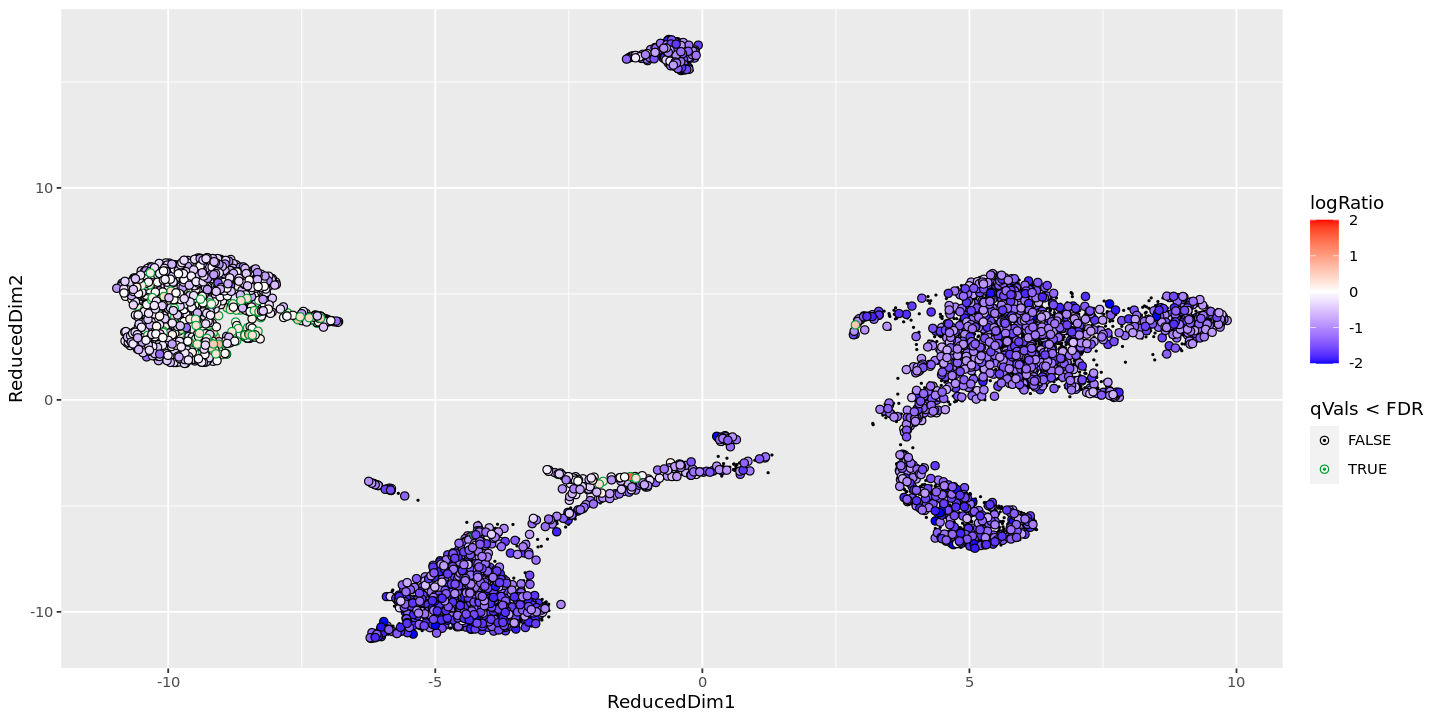

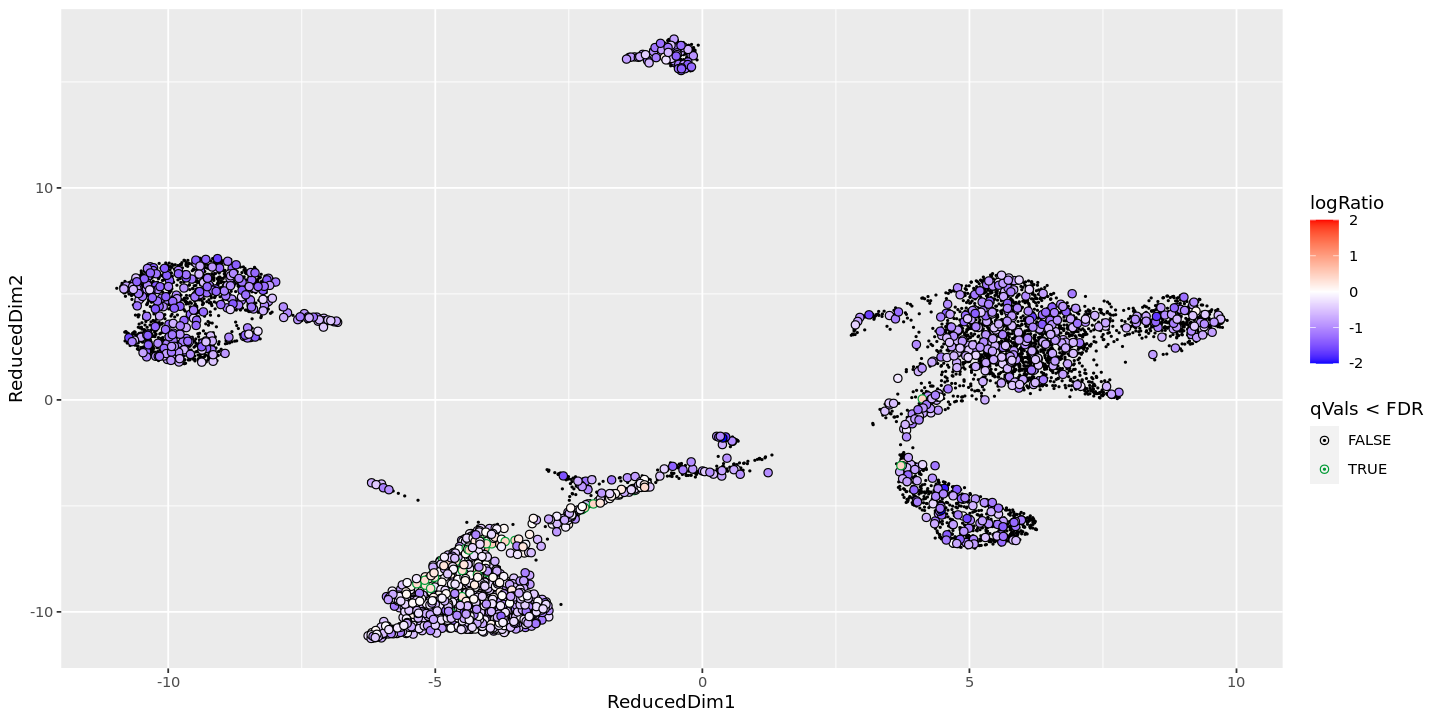

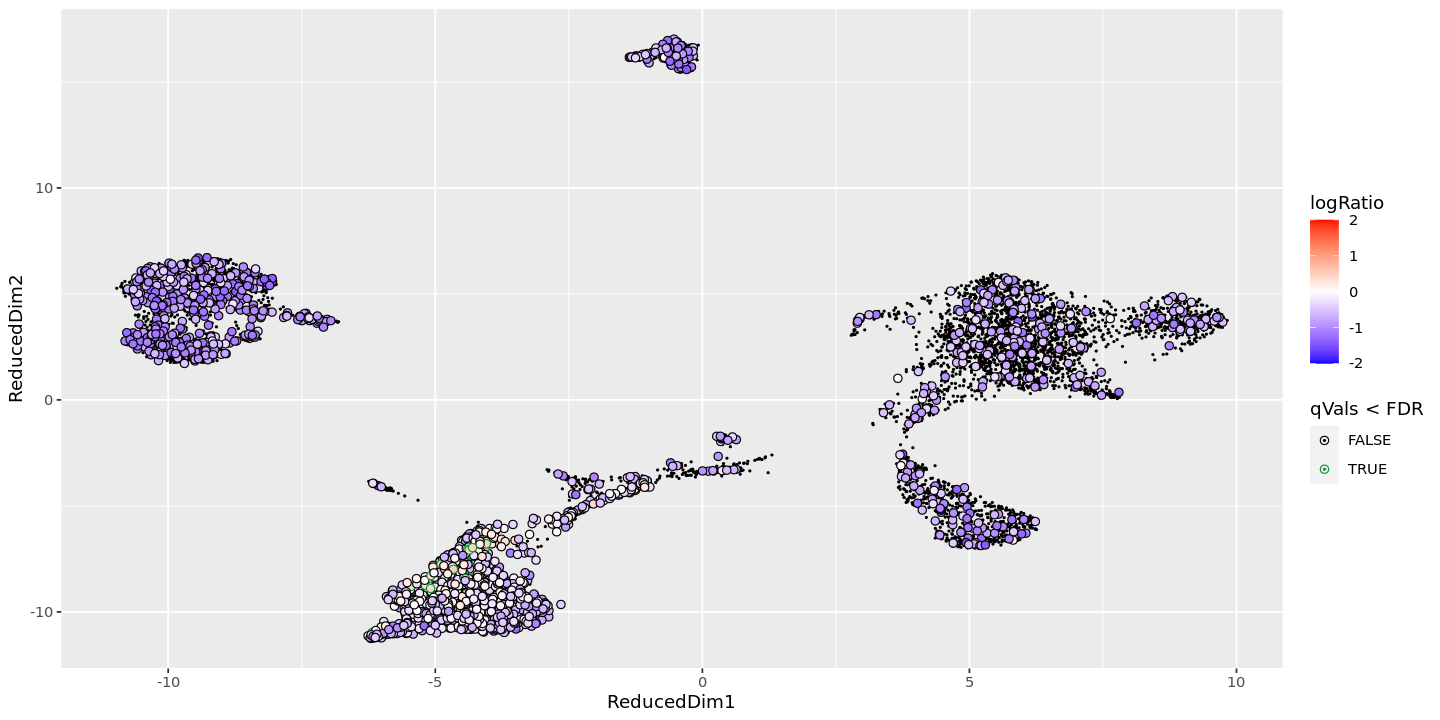

In [30]:
#marker map: check if the expression of a gene is 
#"more than we would expect by chance from the soup" 
# RED --> not from soup, BLUE --> from soup
gg = plotMarkerMap(sc,'INS')
plot(gg)
gg = plotMarkerMap(sc,'GCG')
plot(gg)
gg = plotMarkerMap(sc,'TTR')
plot(gg)

## Defining the Contamination Fraction
### Option 1 - Automated method for defining noise -- DON'T USE

In [41]:
#sc = autoEstCont(sc)

### Option 2 - Manually set noise to a single value -- DON'T USE

In [42]:
#contam_rate <- 0.117
#sc = setContaminationFraction(sc,contam_rate)

### Option 3 - Use the marker genes method to calculate noise

In [103]:
#check out the genes most expressed in the background
#they suggest not just taking this list, but is interesting to see
head(sc$soupProfile[order(sc$soupProfile$est,decreasing=TRUE),],n=20)

est         counts
MALAT1  0.022479570 33700 
MT-CO3  0.014597712 21884 
MT-CO2  0.013206247 19798 
MT-ND3  0.012365765 18538 
INS     0.010904259 16347 
MT-ATP6 0.009678222 14509 
MT-ND1  0.008644962 12960 
MT-ND2  0.007841835 11756 
MT-CYB  0.007629046 11437 
NEAT1   0.006038800  9053 
MT-ND4  0.004658007  6983 
MT-CO1  0.004544609  6813 
GCG     0.003353925  5028 
TTR     0.002594156  3889 
PAM     0.002590153  3883 
ZFAND3  0.002242621  3362 
FNDC3B  0.002111879  3166 
MT-ND5  0.001967129  2949 
RGS7    0.001682299  2522 
DTNA    0.001554893  2331

In [42]:
#read in SoupX marker gene sets from file (currently supports only one gene per 4 groups)
soupx.markers.fp <- '/nfs/lab/projects/multiomic_islet/references/islet_SoupX_markers.txt'
soupx.markers <- read.table(soupx.markers.fp, sep='\t', header=TRUE)
head(soupx.markers)

Gene Group
1 INS  Beta 
2 GCG  Alpha
3 SST  Delta
4 PPY  Gamma

In [50]:
#now manually create gene sets based off of what we think cluster 
#specific marker genes are. Basically you want sets of genes that 
#should be expressed strongly AND in only a few cell types. 
#Thus, if you see these genes in other cells, they are likely entirely from 
#the background soup. For islets we use the four main hormones.
Genes1 <- c(soupx.markers$Gene[[1]])
Genes2 <- c(soupx.markers$Gene[[2]])
Genes3 <- c(soupx.markers$Gene[[3]])
Genes4 <- c(soupx.markers$Gene[[4]])

In [51]:
#select which cells to use with which gene sets to estimate contamination rate
#by adding cluster information we can get better results (applies decisions to
#all cells in a cluster which refines the sets we use)
useToEst = estimateNonExpressingCells(
    sc,
    nonExpressedGeneList = list(A=Genes1, B=Genes2, C=Genes3, D=Genes4),)

#visualize which BCs are being used with which gene sets to estimate
head(useToEst)
table(useToEst) #visualize total true and false values in the table 

A     B     C    D    
AAACAGCCACCTGCCT-1 FALSE FALSE TRUE FALSE
AAACAGCCACGGTTTA-1  TRUE  TRUE TRUE  TRUE
AAACAGCCATTGCAGC-1 FALSE FALSE TRUE FALSE
AAACATGCAACACCTA-1  TRUE  TRUE TRUE  TRUE
AAACATGCAACCCTCC-1 FALSE  TRUE TRUE  TRUE
AAACATGCAATAGCAA-1  TRUE  TRUE TRUE  TRUE

useToEst
FALSE  TRUE 
 8273 20235 

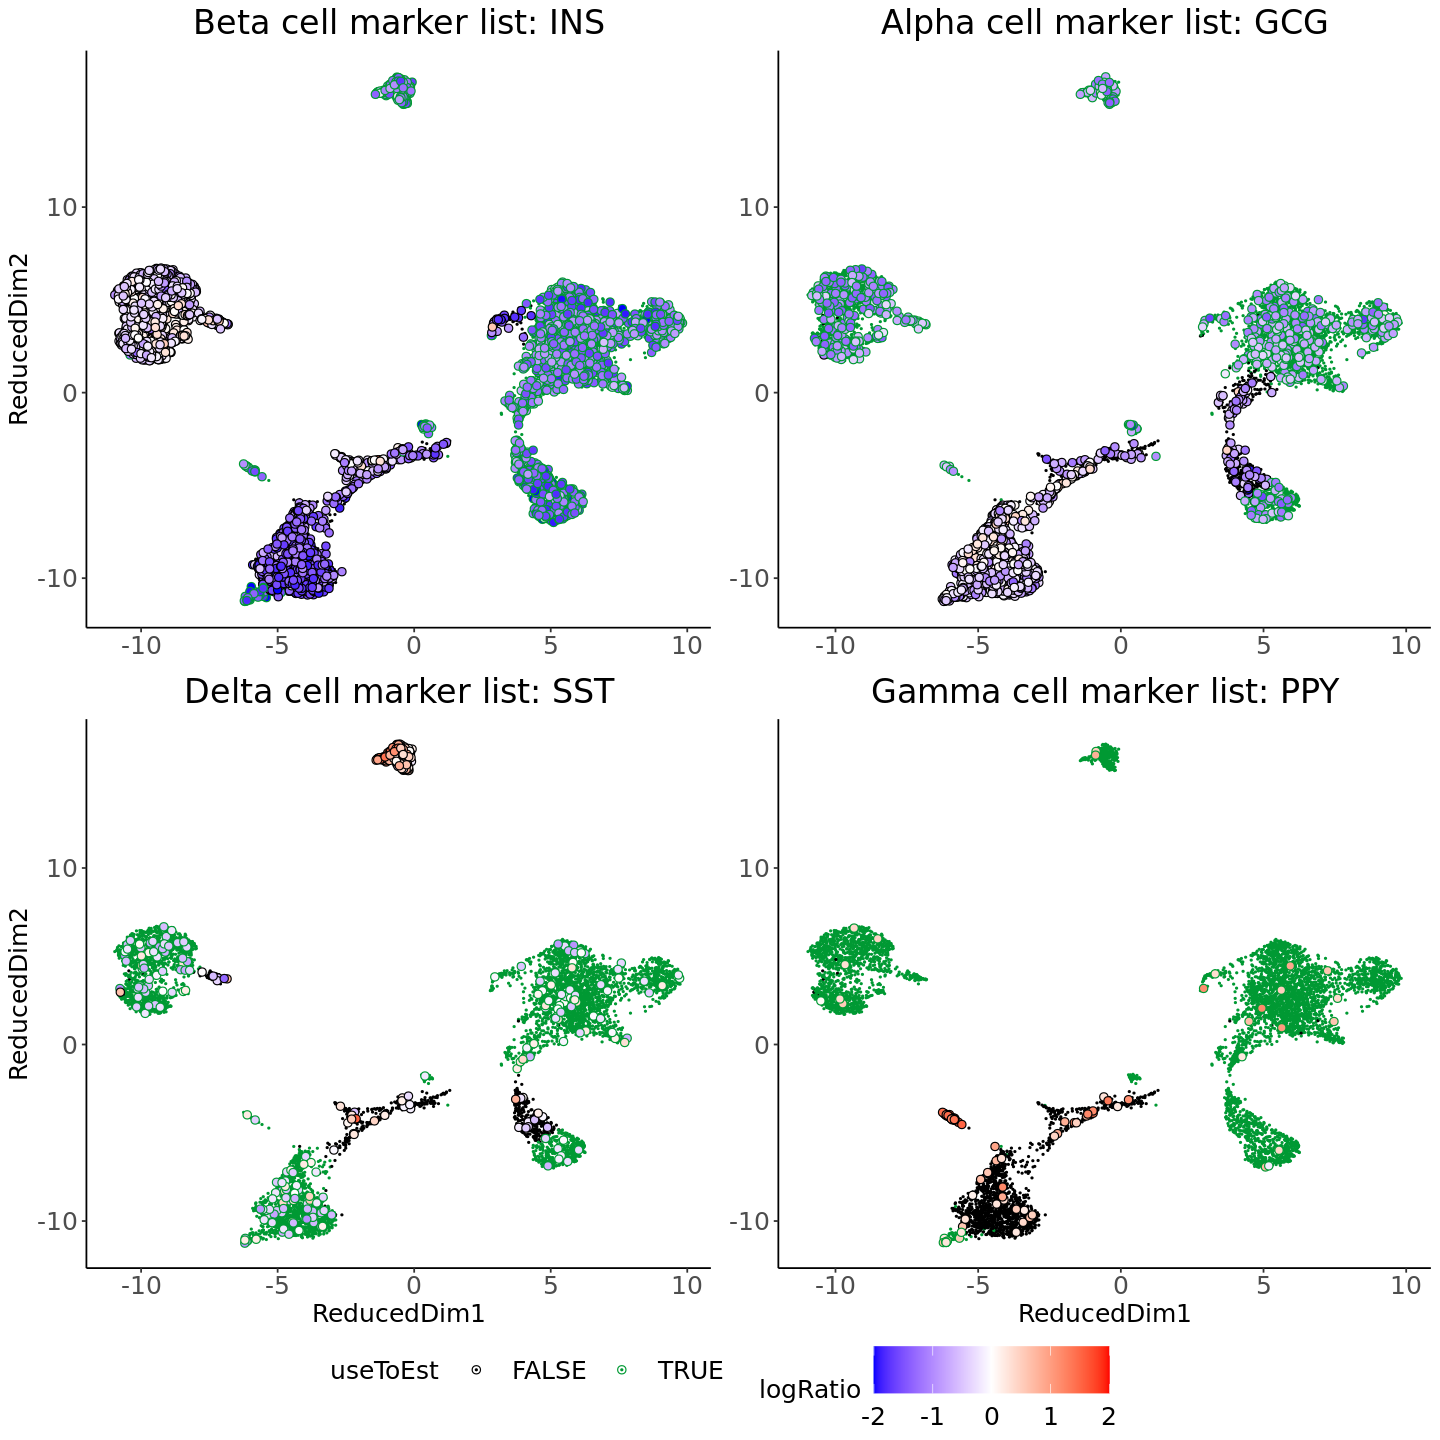

In [54]:
options(repr.plot.width=12, repr.plot.height=12)
theme_set(theme_bw() + 
          theme(panel.border = element_blank(), panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                plot.title = element_text(size = 20, hjust = 0.5),
                legend.key.size = unit(1, 'cm'), legend.title = element_text(size=15),
                legend.text = element_text(size=15),
                axis.title = element_blank(), axis.text = element_text(size=15))
          )

titles <- paste(soupx.markers$Group, "cell marker list:",soupx.markers$Gene,sep=" ")
plot1 <- plotMarkerMap(sc,geneSet=Genes1,useToEst=useToEst[,"A"]) +
        ggtitle(titles[[1]]) + theme(axis.title.y = element_text(size=15)) 
plot2 <- plotMarkerMap(sc,geneSet=Genes2,useToEst=useToEst[,"B"]) + 
        ggtitle(titles[[2]]) 
plot3 <- plotMarkerMap(sc,geneSet=Genes3,useToEst=useToEst[,"C"]) + 
        ggtitle(titles[[3]]) + theme(axis.title.y = element_text(size=15), axis.title.x = element_text(size=15)) 
plot4 <- plotMarkerMap(sc,geneSet=Genes4,useToEst=useToEst[,"D"]) + 
        ggtitle(titles[[4]]) + theme(axis.title.x = element_text(size=15)) 
figure <- ggarrange(plot1, plot2, plot3, plot4, ncol = 2, nrow = 2,
                   common.legend = TRUE,legend="bottom")
figure

In [34]:
#finally use these marker genes and cells to calculate the contamination fraction in each cell
sc = calculateContaminationFraction(sc,
                                    list(A=Genes1, B=Genes2, C=Genes3, D=Genes4),
                                    useToEst=useToEst)

Estimated global contamination fraction of 2.60%



In [41]:
#printout the estimated background contamination
print(paste('Estimated global contamination fraction:',100*exp(coef(sc$fit))[[1]],"%"))

[1] "Estimated global contamination fraction: 2.60317026751563 %"


### Correct the Expression Profile

In [56]:
out = adjustCounts(sc)

Expanding counts from 17 clusters to 7127 cells.



In [57]:
dim(out)
#head(out)

[1] 36601  7127

# Visualize Changes to Expression Profile Post SoupX
We've created a variety of more complex plots to examine how gex counts changed in cell types of interest, but I think just looking at the change maps should be fine here (and is still informative!).

In [61]:
#read in marker genes short list from a file
markers.fp2 <- '/nfs/lab/projects/multiomic_islet/references/islet_markers_shortlist.txt'
marker.genes.short <- scan(markers.fp2,what="",sep="\n")
marker.genes.short

#select only for genes found in our data (only want 9)
gene_names <- row.names(out)
master_list <- marker.genes.short[marker.genes.short %in% gene_names]
master_list <- master_list[seq(1,9)]
master_list

[1] "INS"    "GCG"    "PPY"    "SST"    "REG1A"  "CFTR"   "CD69"   "PDGFRB"
[9] "PDX1"

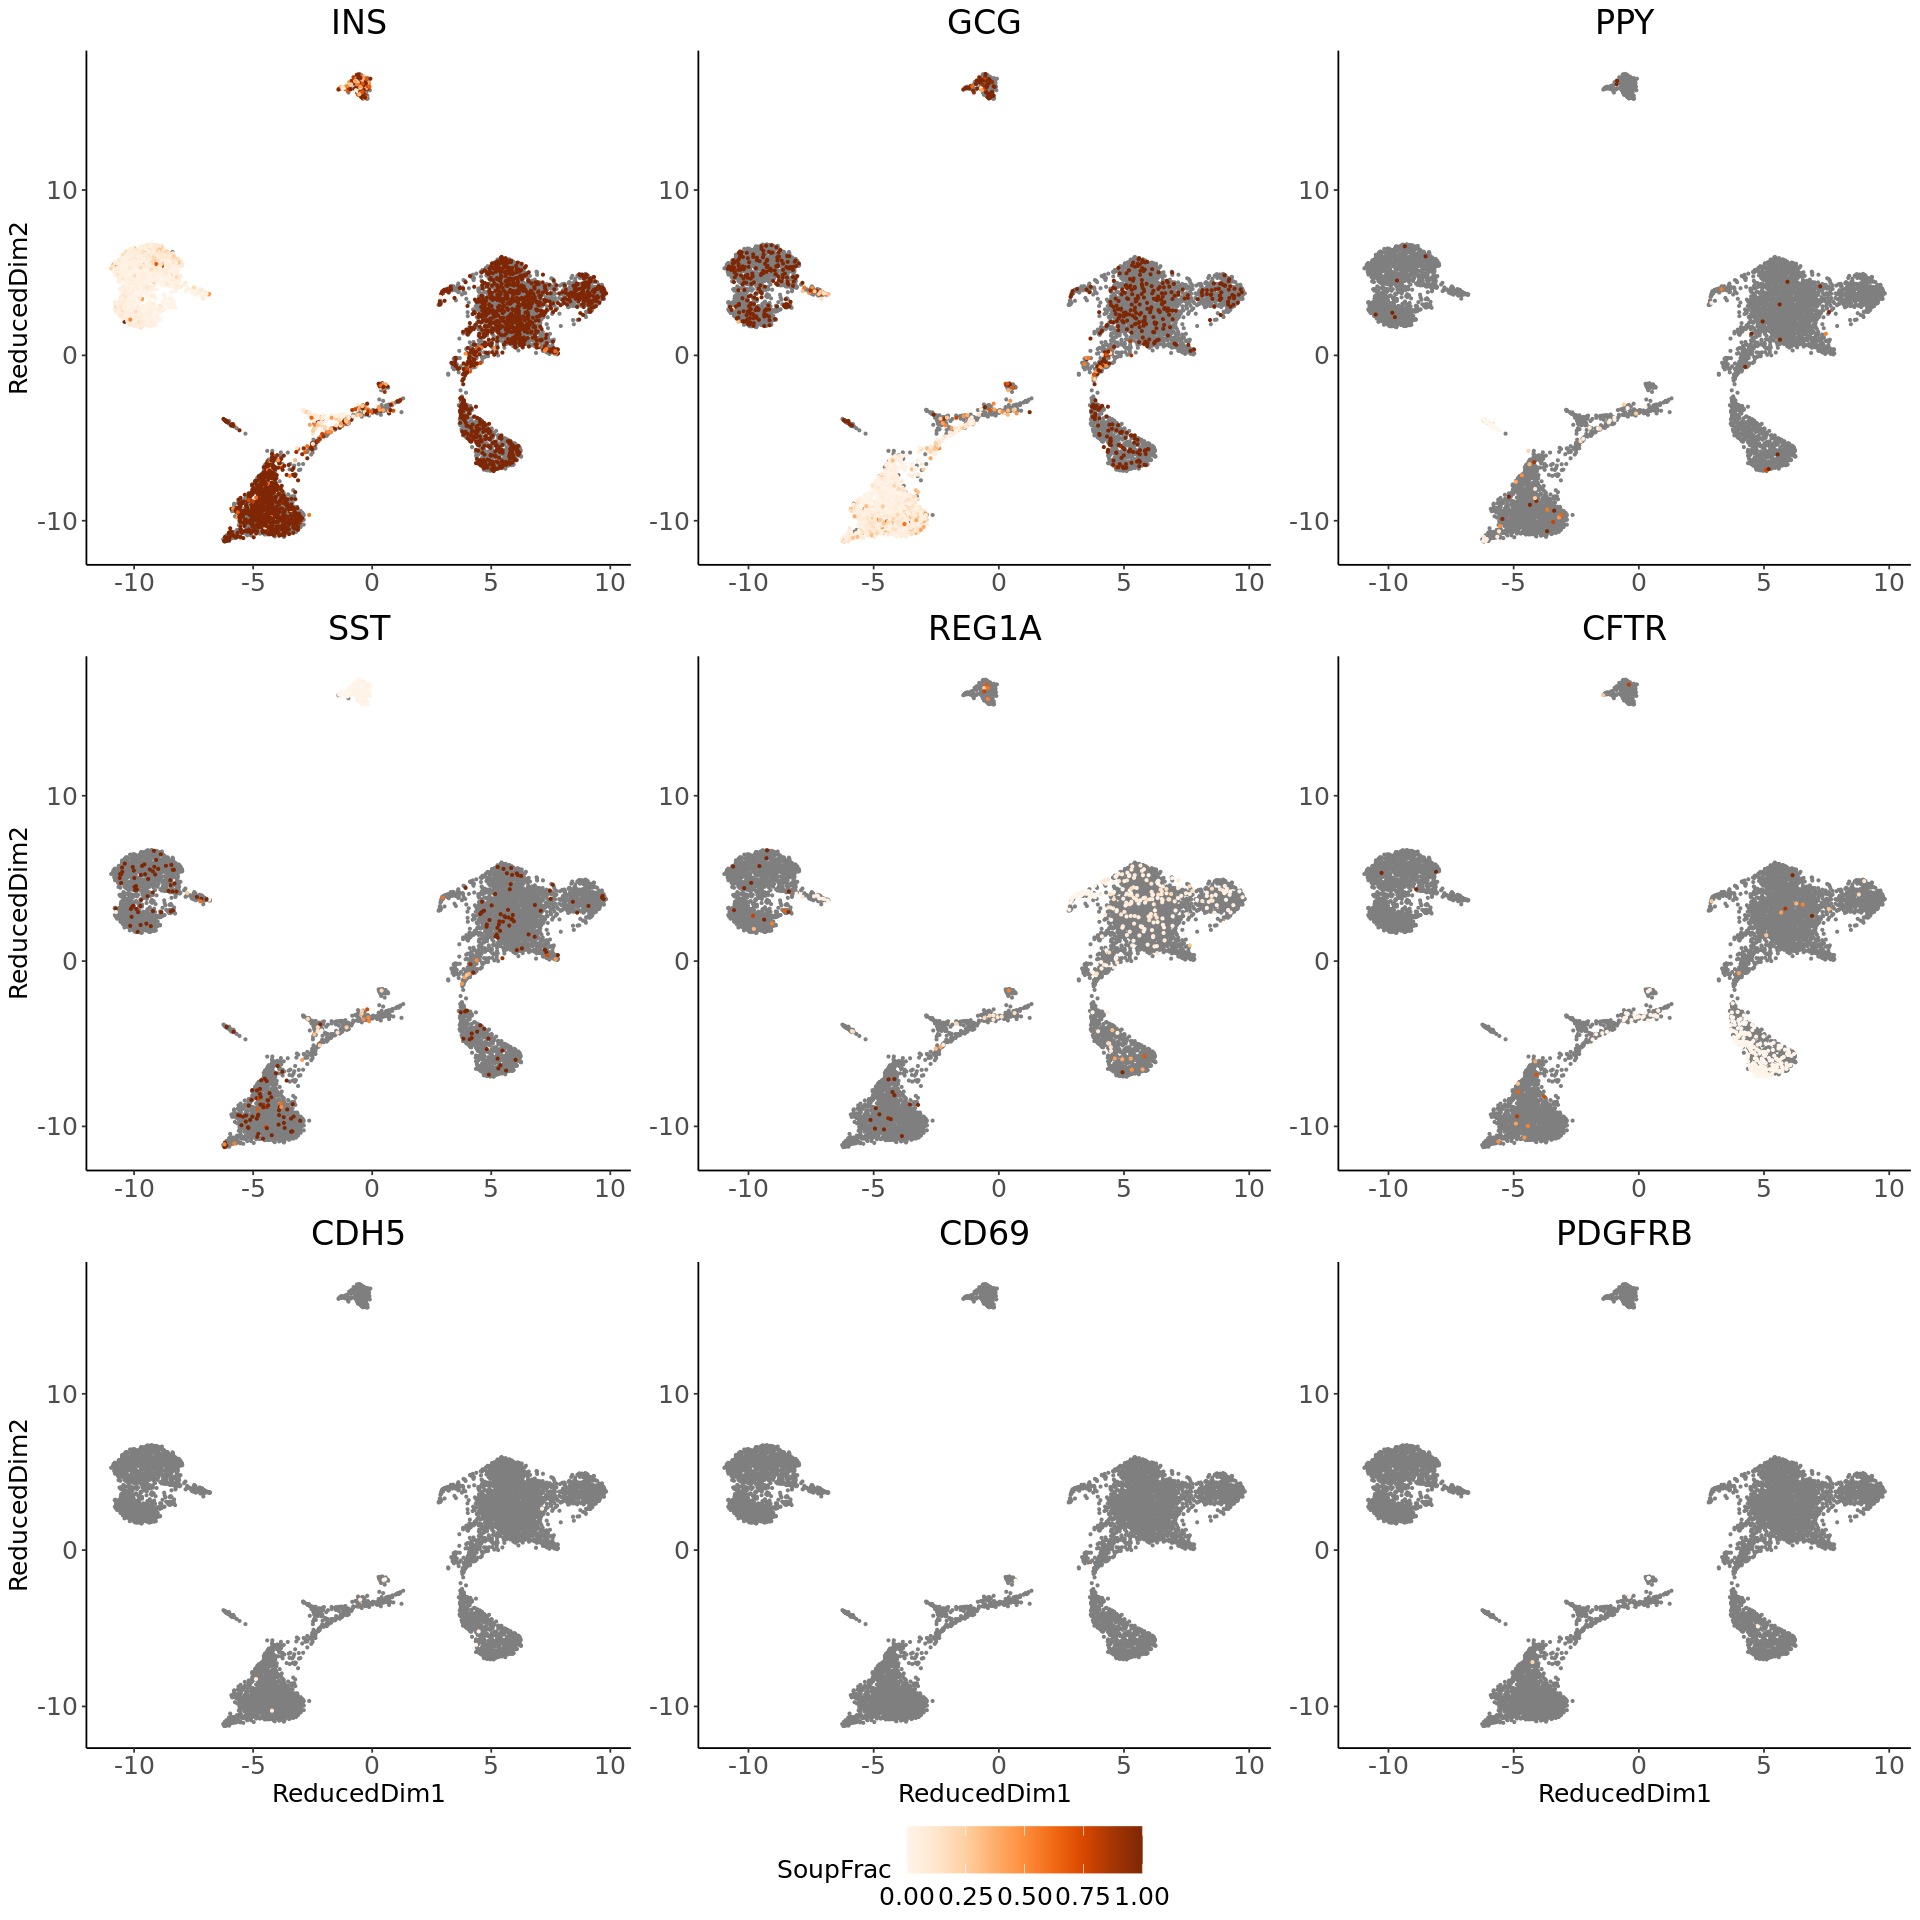

In [182]:
#visualize how counts have been changed
#color corresponds to what fraction of the gex was attributed to the soup (vs real signal)
#red = most of gex was from soup, white = most of gex was real expression
#grey = no gex in that cell
options(repr.plot.width=16, repr.plot.height=16)
theme_set(theme_bw() + 
          theme(panel.border = element_blank(), panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                plot.title = element_text(size = 20, hjust = 0.5),
                legend.key.size = unit(1, 'cm'), legend.title = element_text(size=15),
                legend.text = element_text(size=15),
                axis.title = element_blank(), axis.text = element_text(size=15))
          )
plot1 <- plotChangeMap(sc,out,master_list[[1]]) + ggtitle(master_list[[1]]) + theme(axis.title.y = element_text(size=15)) 
plot2 <- plotChangeMap(sc,out,master_list[[2]]) + ggtitle(master_list[[2]])
plot3 <- plotChangeMap(sc,out,master_list[[3]]) + ggtitle(master_list[[3]])
plot4 <- plotChangeMap(sc,out,master_list[[4]]) + ggtitle(master_list[[4]]) + theme(axis.title.y = element_text(size=15)) 
plot5 <- plotChangeMap(sc,out,master_list[[5]]) + ggtitle(master_list[[5]])
plot6 <- plotChangeMap(sc,out,master_list[[6]]) + ggtitle(master_list[[6]])
plot7 <- plotChangeMap(sc,out,master_list[[7]]) + ggtitle(master_list[[7]]) + theme(axis.title.x = element_text(size=15),axis.title.y = element_text(size=15))  
plot8 <- plotChangeMap(sc,out,master_list[[8]]) + ggtitle(master_list[[8]]) + theme(axis.title.x = element_text(size=15)) 
plot9 <- plotChangeMap(sc,out,master_list[[9]]) + ggtitle(master_list[[9]]) + theme(axis.title.x = element_text(size=15)) 

figure <- ggarrange(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, 
                    ncol = 3, nrow = 3, common.legend = TRUE,legend="bottom")
figure

# Create post-SoupX Seurat Object and Add in the ATAC Windows Counts

In [64]:
adata2 = CreateSeuratObject(out)
adata2[['percent.mt']] <- PercentageFeatureSet(adata2, pattern = '^MT-')

In [65]:
adata2

An object of class Seurat 
36601 features across 7127 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [73]:
#add in previous raw RNA data as another assay
DefaultAssay(adata) <- 'RNA'
raw_rna <-  GetAssayData(object = adata, slot = "counts")

raw_rna_assay <- CreateAssayObject(counts = raw_rna)
adata2[['RNA_raw']] <- raw_rna_assay

In [74]:
adata2

An object of class Seurat 
73202 features across 7127 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: RNA_raw

In [75]:
#pull out the RNA BCs order, for use in making the atac_counts sparse matrix
bc_order <- colnames(adata2[["RNA"]])
head(bc_order)
out_dir <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s',sample)
bc_fp <- file.path(out_dir,sprintf("filtered_barcodes.txt",sample))
write(bc_order, file=bc_fp, sep = '\n')

[1] "AAACAGCCACCTGCCT-1" "AAACAGCCACGGTTTA-1" "AAACAGCCATTGCAGC-1"
[4] "AAACATGCAACACCTA-1" "AAACATGCAACCCTCC-1" "AAACATGCAATAGCAA-1"

# Call the script that makes the ATAC windows matrix

This is too complicated to run in an R jupyter notebook so you'll need to run it from the terminal. This should take 8-9 hours to run because it's generating a lot of useful files for downstream analyses so definitely run it in a screen! The script is located at `/nfs/lab/projects/multiomic_islet/code/indv_sample_processing/2ATAC_processing_v2.py`, and you should copy it to your dir. You'll need to provide it with a variety of CellRanger outputs and the barcode list you just wrote out in the previous cell.

- Inputs: --bam (`atac_possorted_bam.bam`), --keep (`filtered_barcodes.txt`), --outdir (wherever you're outputting files, `out_dir`), --fragments (`atac_fragments.tsv.gz`)
- Outputs: `atac_fragments.filtered_barcode.tsv.gz`, `atac_possorted_reads.filtered_barcode.bed.gz`, `atac.long_fmt.filtered_barcode.mtx`, `atac_keep_reads.tagAlign.gz`, and some other bam file intermediates.

### Important Note:
The input files **MUST** be located in a directory that you have write access to (check the permissions with `ls -l` or try to make a test file in the directory with `touch test.txt`). If they are not, copy the files to one of your directories before running this (and then delete them afterwards to save space!).


Example run:


`sample=R221
sample_dir="/nfs/lab/projects/multiomic_islet/data/multiomics/cellranger/deep-shallow/R221/outs/"
ATAClfm_Pyscript_fp="/nfs/lab/projects/multiomic_islet/code/indv_sample_processing/2ATAC_processing_v2.py"
outs_dir="/nfs/lab/hmummey/multiomic_islet/intermediates/220106_multiome_pipeline_v2_tests/R221"
log_file="$outs_dir/log_file.txt"`


`cd $sample_dir
python $ATAClfm_Pyscript_fp --bam "atac_possorted_bam.bam" --keep $outs_dir"/filtered_barcodes.txt" --outdir $outs_dir --fragments "atac_fragments.tsv.gz"  >> $log_file`

Script dependencies: os, gzip, argparse, subprocess, pysam, numpy, pandas, scipy.sparse, multiprocessing, datetime


Also you'll need to change a few of the chmod permissions of the output scripts and gzip one of the output files manually:
`chmod -R ugo+rwx "$outs_dir/atac_fragments.filtered_barcode.tsv.gz"
chmod -R ugo+rwx "$outs_dir/atac_possorted_reads.filtered_barcode.bed.gz"
chmod -R ugo+rwx "$outs_dir/atac_possorted_bam.filt.rmdup.bam"
gzip "$outs_dir/atac.long_fmt.filtered_barcode.mtx"
chmod -R ugo+rwx "$outs_dir/atac.long_fmt.filtered_barcode.mtx.gz"`

### Read in the ATAC long format matrix and create a sparse matrix with the desired BC order

In [136]:
#read in the long format matrix as a table
#gzip this in the terminal before reading in here!
out.dir <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s',sample)
atac_lfm <- read.table(file.path(out.dir, 'atac.long_fmt.filtered_barcode.mtx.gz'), sep='\t', header=FALSE, stringsAsFactors=FALSE)

In [137]:
#we need to make sure the ATAC BCs match the one currently in adata2$RNA
#first double check that all desired BCs are found in the ATAC BCs (and vice versa)
table(bc_order %in% atac_lfm$V2)
table(atac_lfm$V2 %in% bc_order)


TRUE 
7127 


     TRUE 
106396135 

In [138]:
#now set the levels of the lfm based on the desired bc order and reorder based on them
atac_lfm$V2 <- factor(atac_lfm$V2, levels=bc_order)
reordered_lfm <- atac_lfm[order(atac_lfm$V2),]

#do the factoring for windows (V1) in whatever order (automatically alphanumeric?)
reordered_lfm$V1 <- as.factor(reordered_lfm$V1)
head(reordered_lfm)

#finally make the ATAC sparse matrix and double check the BC order is correct
atac_counts2 <- with(reordered_lfm,sparseMatrix(i=as.numeric(V1), j=as.numeric(V2), x=V3, dimnames=list(levels(V1), levels(V2))))
table(colnames(atac_counts2) == bc_order)
dim(atac_counts2)
#head(atac_counts2$Dimnames[1])
#head(atac_counts2)

V1                        V2                 V3
396   chr10-100000-105000       AAACAGCCACCTGCCT-1 2 
9032  chr10-100185000-100190000 AAACAGCCACCTGCCT-1 4 
15355 chr10-100285000-100290000 AAACAGCCACCTGCCT-1 2 
53808 chr10-100895000-100900000 AAACAGCCACCTGCCT-1 2 
53954 chr10-100900000-100905000 AAACAGCCACCTGCCT-1 5 
54204 chr10-100905000-100910000 AAACAGCCACCTGCCT-1 2


TRUE 
7127 

[1] 569024   7127

In [139]:
#assemble the other necessary components for a chromatin assay object
grange.counts2 <- StringToGRanges(rownames(atac_counts2), sep = c(':', '-'))
grange.use2 <- seqnames(grange.counts2) %in% standardChromosomes(grange.counts2)
atac_counts2 <- atac_counts2[as.vector(grange.use2), ]
annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [140]:
#make the chromatin assay object and add to adata2
#we can just use the original atac_fragments file here (produced by CellRanger)
frag.file2 <- file.path(wd, 'atac_fragments.tsv.gz')
chrom_assay2 <- CreateChromatinAssay(counts=atac_counts2, sep=c(':', '-'), genome='hg38', fragments=frag.file2, min.cells=0, min.features=-1, annotation=annotations)
adata2[['ATAC']] <- chrom_assay2

Computing hash



In [141]:
adata2[['ATAC']]

ChromatinAssay data with 569024 features for 7127 cells
Variable features: 0 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [142]:
adata2

An object of class Seurat 
664701 features across 7127 samples within 4 assays 
Active assay: ATAC (569024 features, 0 variable features)
 3 other assays present: RNA, RNA_raw, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

### Do normal multiomics analyses and plot the results

In [143]:
# RNA analysis
DefaultAssay(adata2) <- 'RNA'
adata2 <- SCTransform(adata2, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')

# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata2) <- 'ATAC'
adata2 <- RunTFIDF(adata2)
adata2 <- FindTopFeatures(adata2, min.cutoff='q0')
adata2 <- RunSVD(adata2)
adata2 <- RunUMAP(adata2, reduction='lsi', dims=2:50, reduction.name='umap.atac', reduction.key='atacUMAP_')

adata2 <- FindMultiModalNeighbors(adata2, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata2 <- RunUMAP(adata2, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata2 <- FindClusters(adata2, graph.name='wsnn', algorithm=3, resolution = .2, verbose=FALSE)

adata2$log_nCount_ATAC = log(adata2$nCount_ATAC)
adata2$log_nCount_SCT = log(adata2$nCount_SCT)
adata2$log_nFeature_ATAC = log(adata2$nFeature_ATAC)
adata2$log_nFeature_SCT = log(adata2$nFeature_SCT)

PC_ 1 
Positive:  CD44, NEAT1, LINC00342, TXNRD1, SLC7A11, ANKRD36C, CHRM3, NIBAN1, ZNF704, SLC38A1 
	   PTPRK, PARD3, CEMIP2, USP53, RAB27B, MYO6, MYO1E, SAT1, EPS8, ABTB2 
	   TANC1, ADAMTS9, RB1CC1, TJP2, GCLC, SHANK2, SVIL, LARGE1, SMAD3, PCSK5 
Negative:  RGS7, PAM, INS, GPC6, HS6ST3, GCG, TTR, CADM1, SPOCK3, CNTNAP5 
	   KCNMA1, FSTL5, CADPS, PDE4D, TMEM132D, SEMA3E, DST, MMP16, SLC35F4, ADAMTS18 
	   ZNF385D, MEIS2, NCAM1, RIMS2, AGBL4, ASAP1, RGS17, LRRTM4, CACNA1C, EML5 
PC_ 2 
Positive:  MT-CO2, MT-CO3, MT-ATP6, MT-ND3, MT-ND1, MT-CYB, MT-ND2, MT-CO1, MT-ND4, MT-ND5 
	   MT-ND4L, ADAMTS9, MT-ATP8, RUNX1, MTRNR2L12, MYOF, AHNAK, DAB1, LAMC2, SGO1-AS1 
	   EGLN3, GCG, BICC1, DNAH12, PDE4C, IGF2BP2, DLG2, PECAM1, SCAI, TTR 
Negative:  SLC7A11, CHRM3, NEAT1, INS, NIBAN1, ZNF385D, PAM, DTNA, RB1CC1, TXNRD1 
	   PLCB1, RAB27B, LINC00342, GULP1, MAML3, MYRIP, AKAP9, KIF1A, MAP3K5, UBE2E2 
	   ALCAM, DENND4A, DOCK10, ANKRD36C, EFNA5, PTPRK, MAP2, KCNN2, SNTB1, ENAH 
PC_ 3 
Positive: 

In [144]:
adata2

An object of class Seurat 
664701 features across 7127 samples within 4 assays 
Active assay: ATAC (569024 features, 569024 variable features)
 3 other assays present: RNA, RNA_raw, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

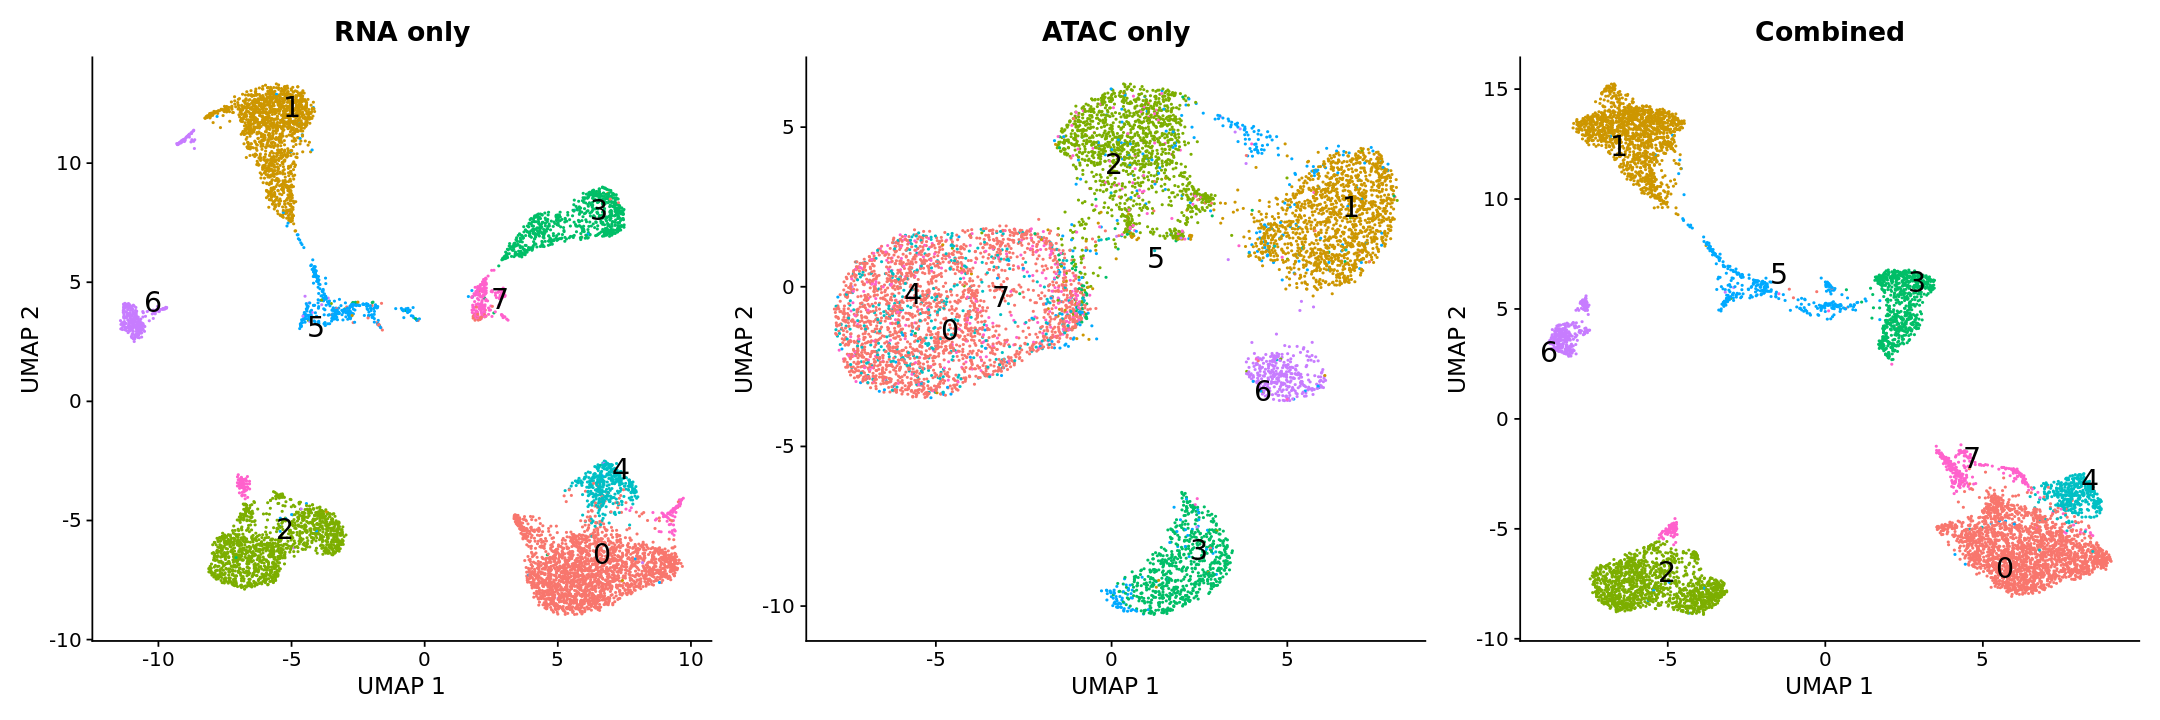

In [145]:
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata2, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata2, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata2, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

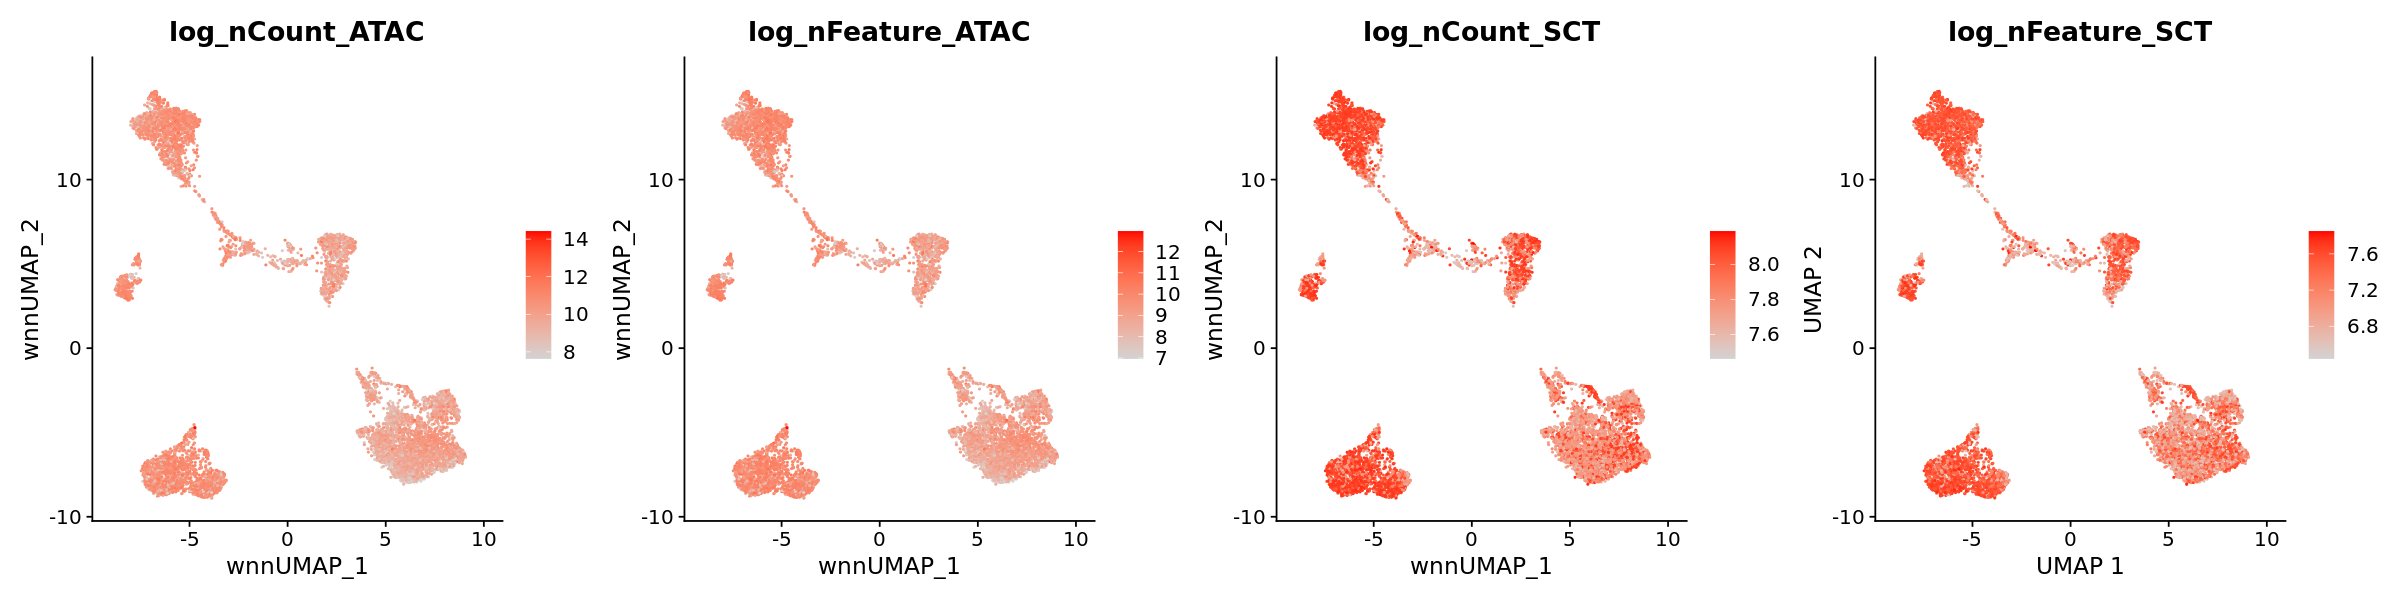

In [146]:
options(repr.plot.width=20, repr.plot.height=5)
p1 <- FeaturePlot(adata2, reduction='umap.wnn', features=c('log_nCount_ATAC','log_nFeature_ATAC','log_nCount_SCT','log_nFeature_SCT'), 
                  cols=c('lightgrey', 'red'), ncol=4) + xlab('UMAP 1') + ylab('UMAP 2')
p1 & theme(plot.title=element_text(hjust=0.5))

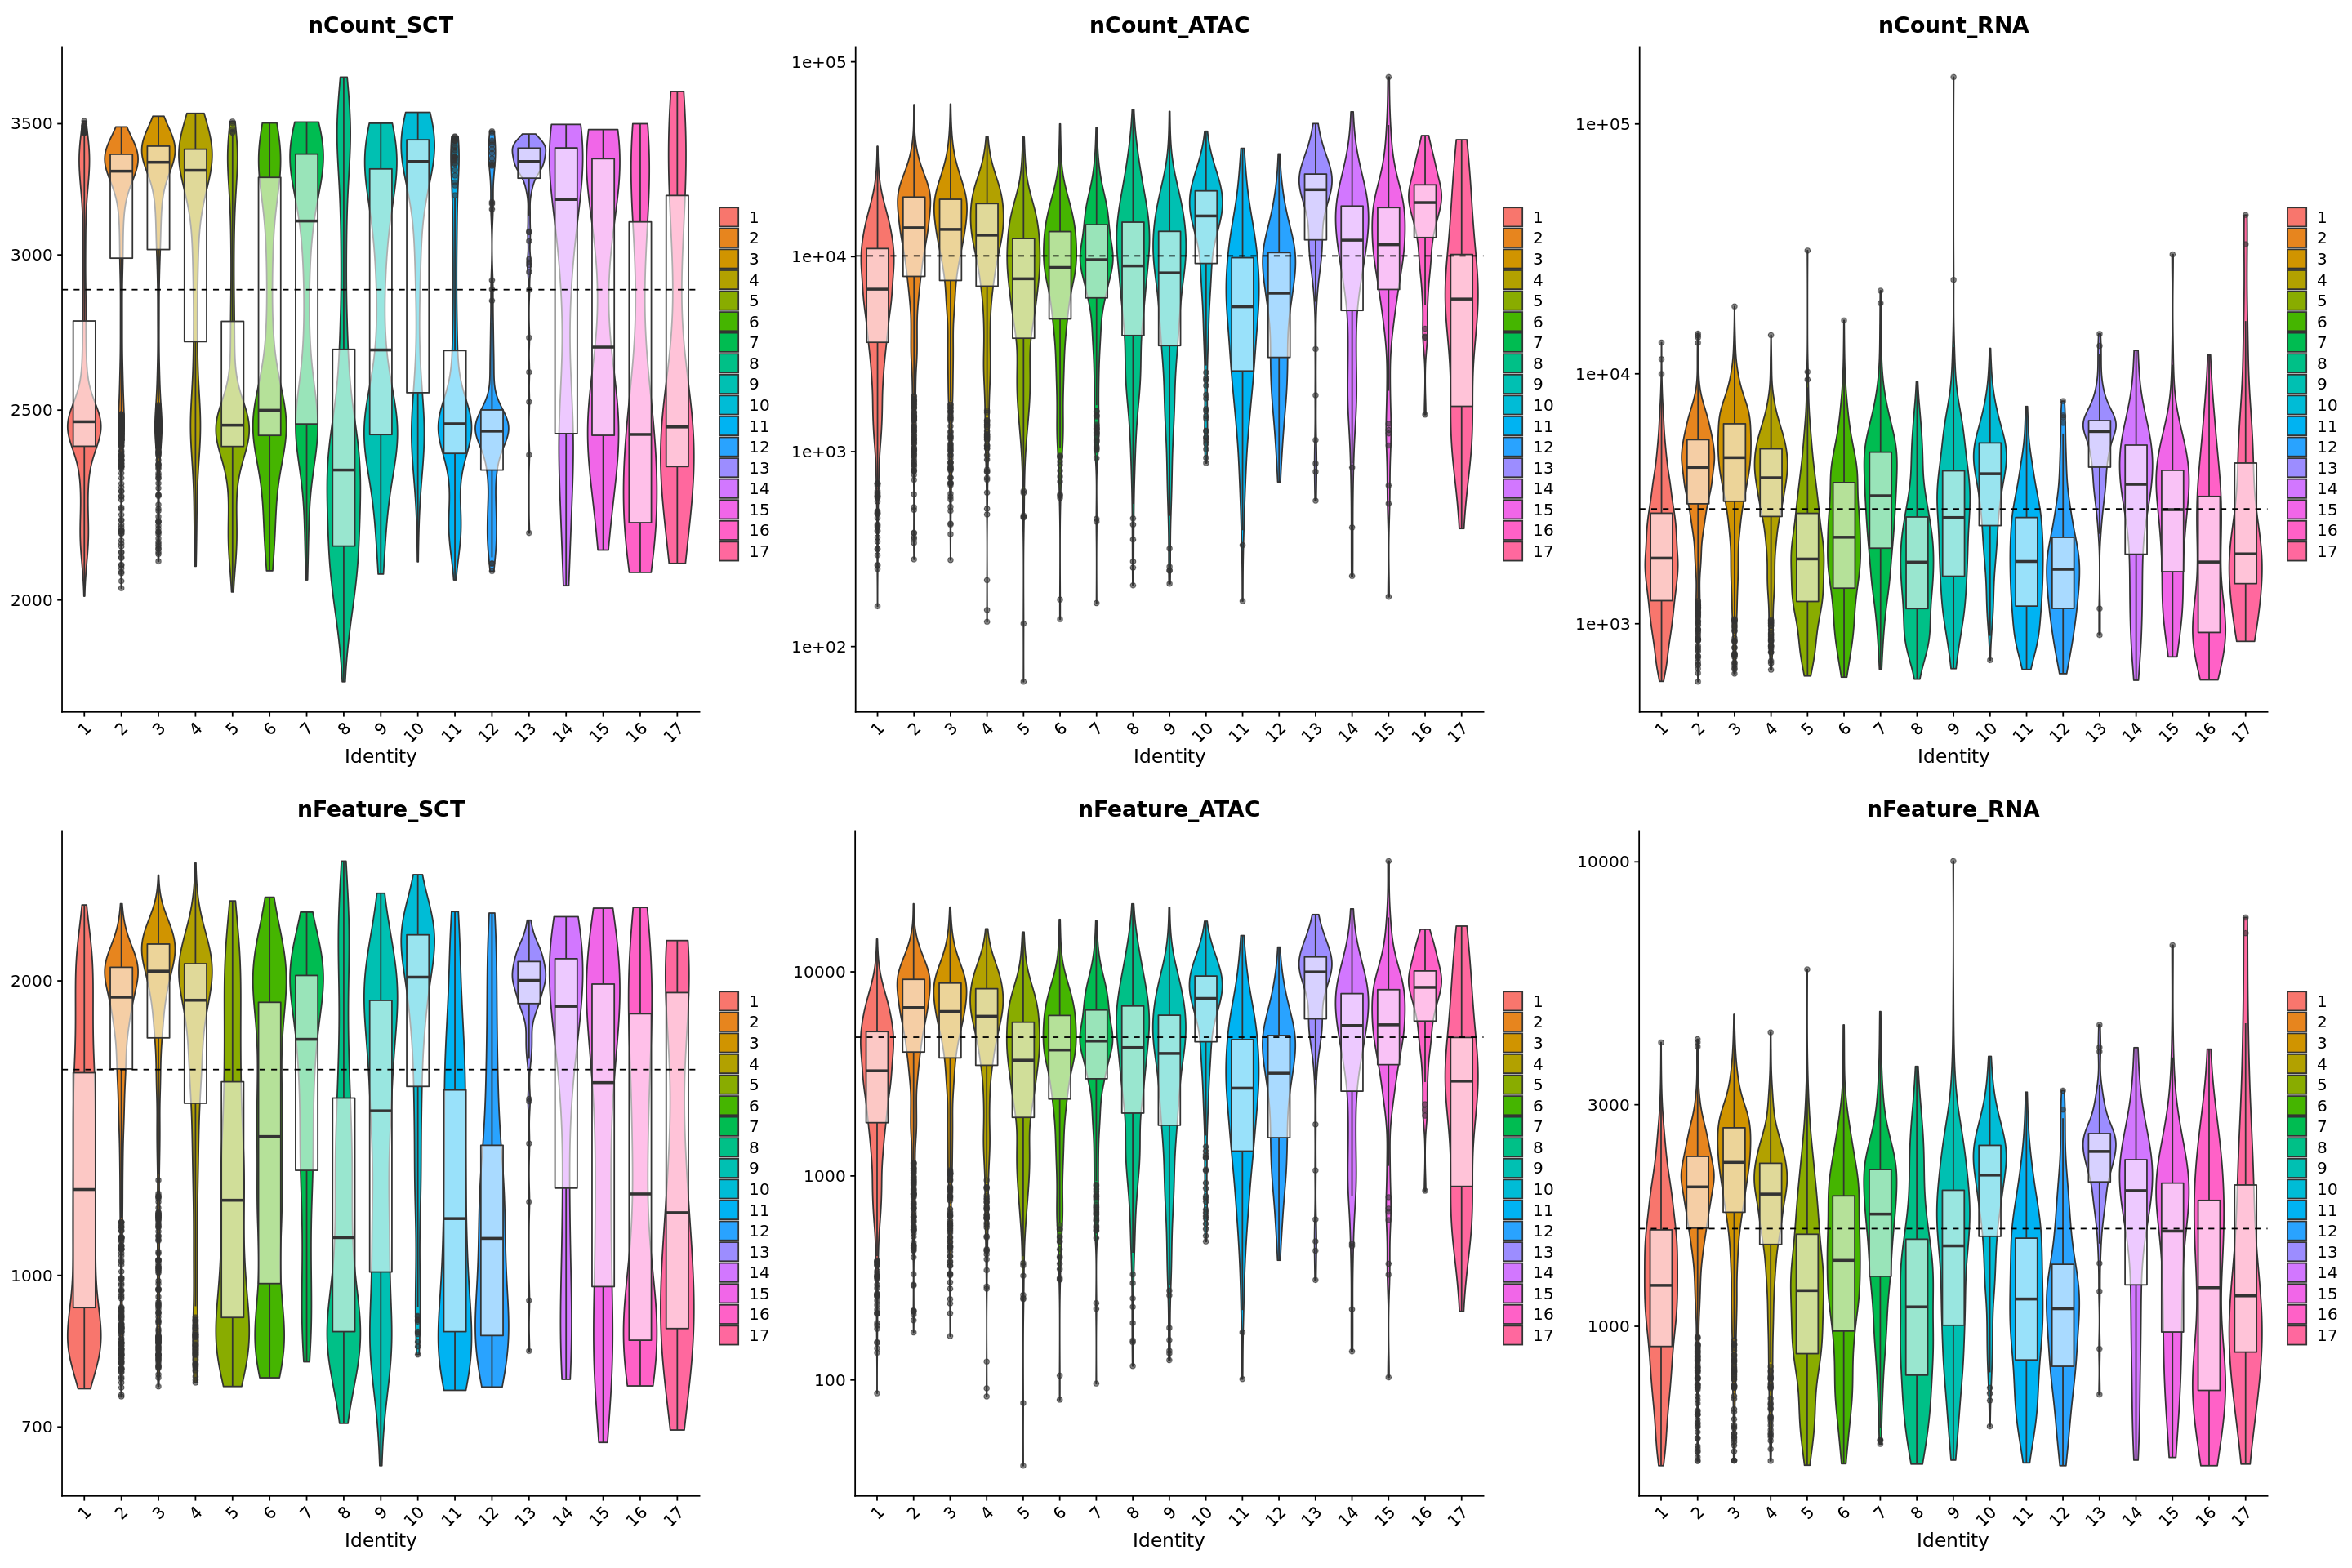

In [87]:
options(repr.plot.width=24, repr.plot.height=16)
p1 <- VlnPlot(adata, features='nCount_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2)
p2 <- VlnPlot(adata, features='nFeature_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2)
p3 <- VlnPlot(adata, features='nCount_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_ATAC), linetype='dashed', lw=2)
p4 <- VlnPlot(adata, features='nFeature_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_ATAC), linetype='dashed', lw=2)
p5 <- VlnPlot(adata, features='nCount_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2)
p6 <- VlnPlot(adata, features='nFeature_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2)
# p1 / p2 
# p3 / p4 
# p5 / p6

figure <- ggarrange(p1, p3, p5, p2, p4, p6, ncol = 3, nrow = 2)
figure

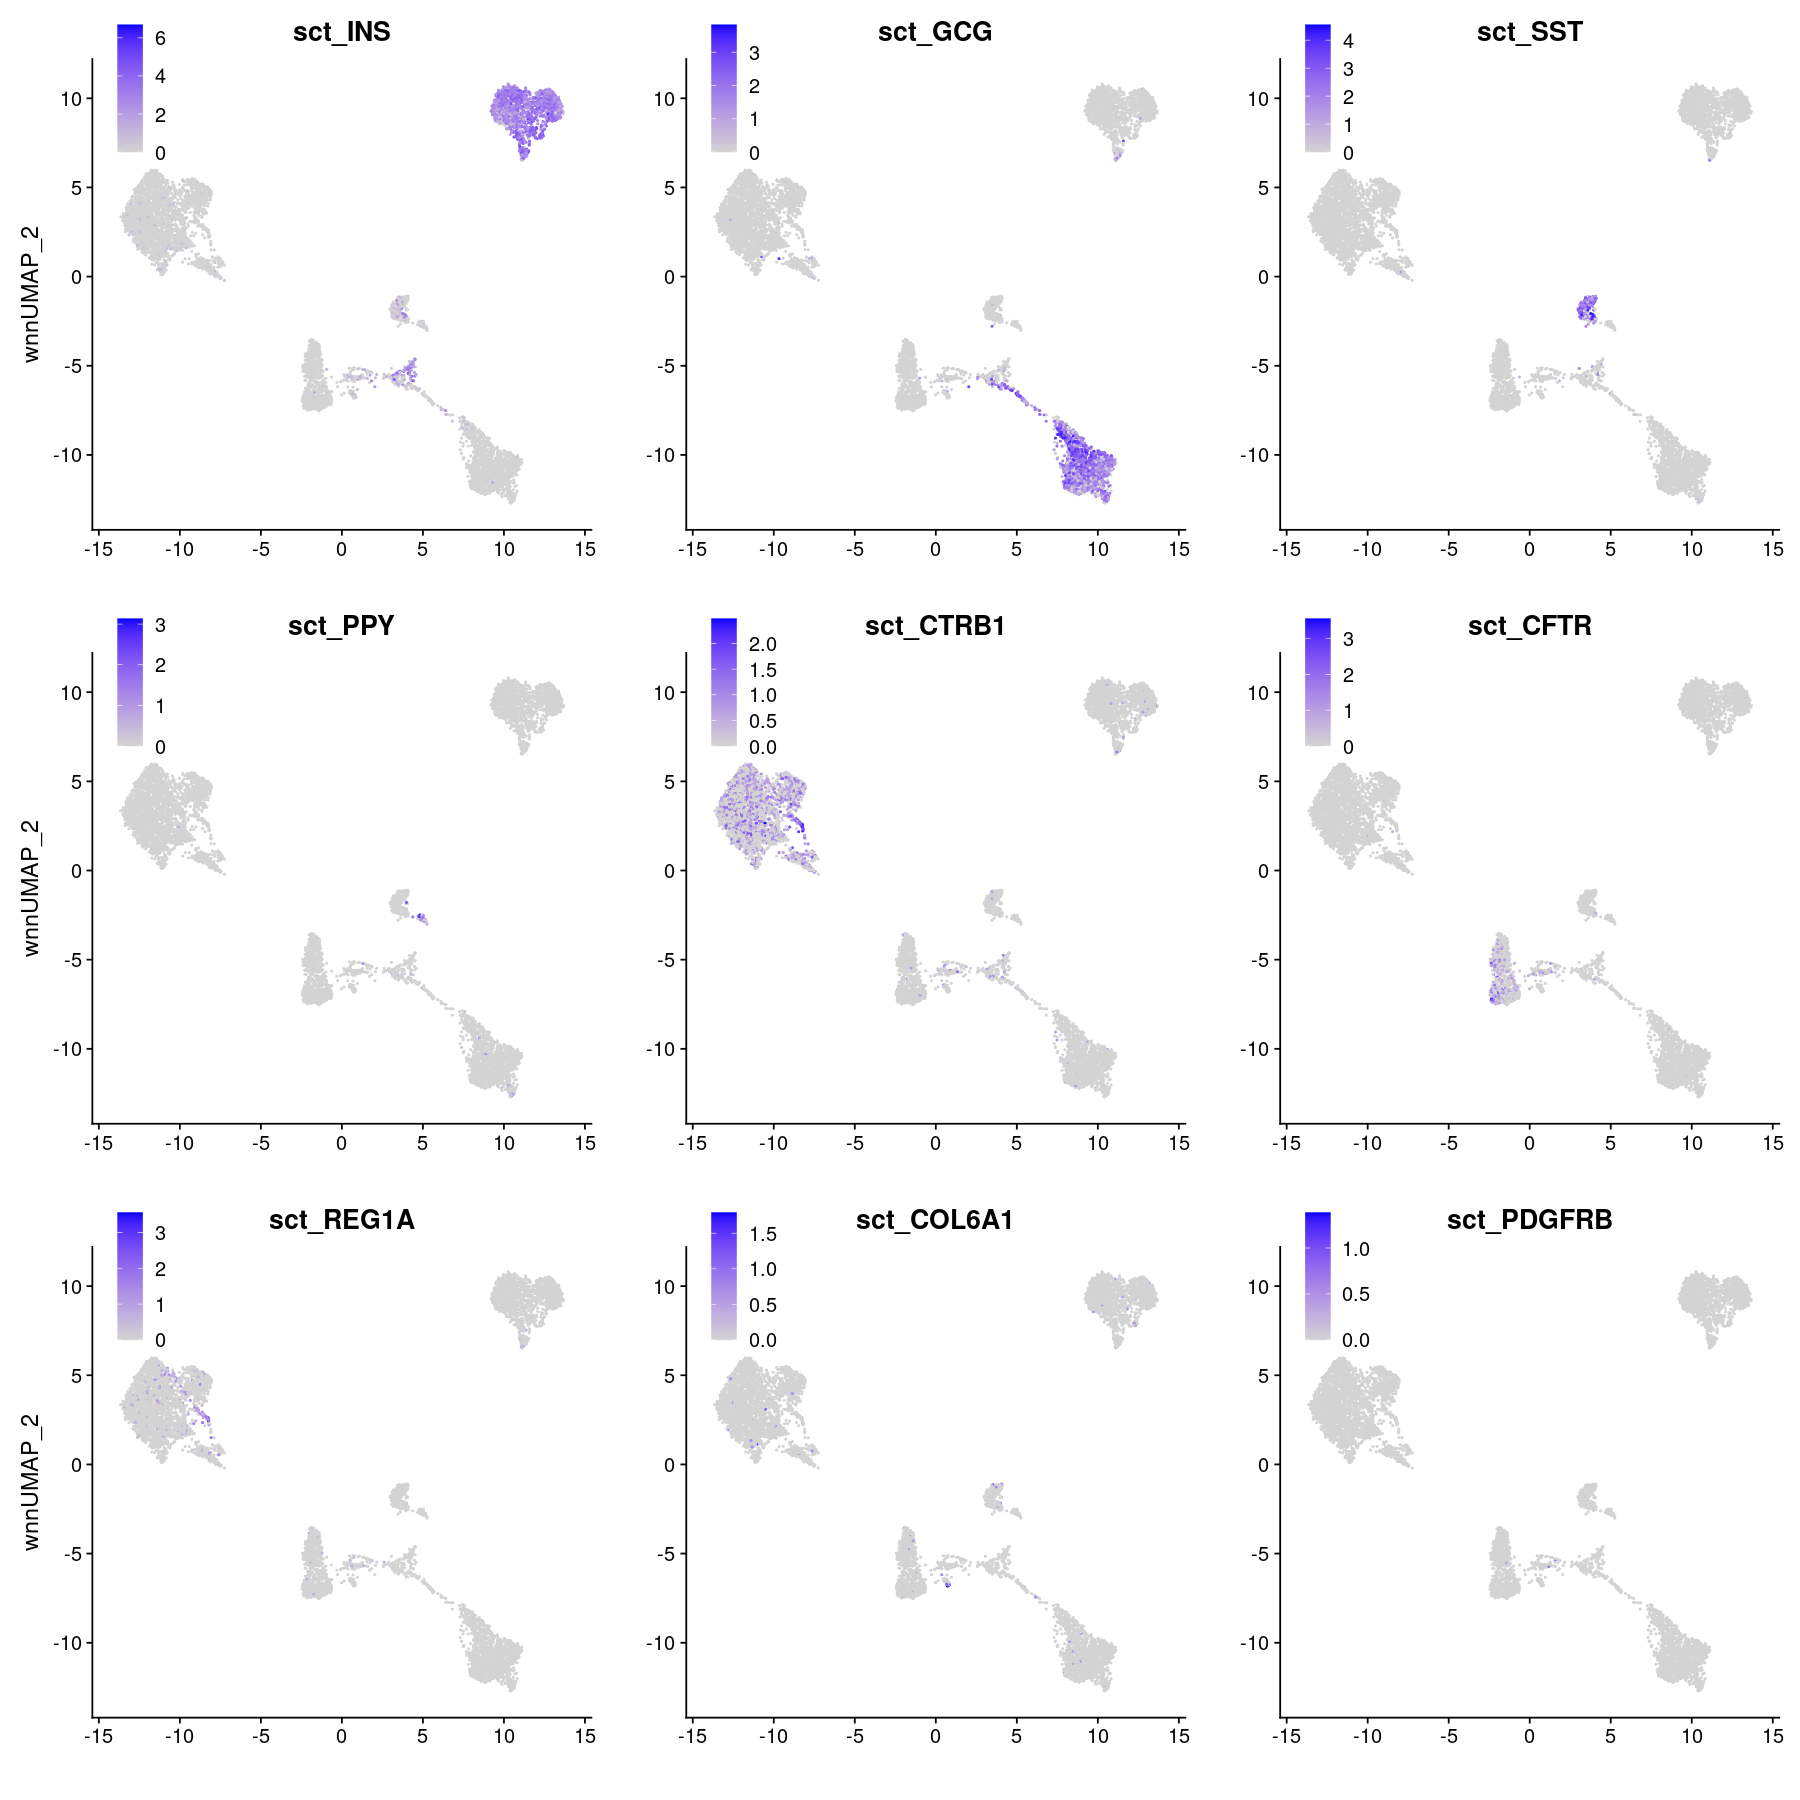

In [132]:
#read in marker genes short list from a file
# markers.fp1 <- '/nfs/lab/projects/multiomic_islet/references/islet_markers_shortlist.txt'
# marker.genes.short <- scan(markers.fp1,what="",sep="\n")
marker.genes.short
sct.marker.genes.short <- paste('sct_',marker.genes.short,sep="")
sct.marker.genes.short

options(repr.plot.width=15, repr.plot.height=15)
p1 <- FeaturePlot(adata2, reduction='umap.wnn', features=sct.marker.genes.short[c(1,2,3)], ncol=3)
p2 <- FeaturePlot(adata2, reduction='umap.wnn', features=sct.marker.genes.short[c(4,5,6)], ncol=3) 
p3 <- FeaturePlot(adata2, reduction='umap.wnn', features=sct.marker.genes.short[c(7,8,9)], ncol=3) 
for (j in c(1,2,3)) {
    p1[[j]] <- p1[[j]] + xlab('')
    p2[[j]] <- p2[[j]] + xlab('')
    p3[[j]] <- p3[[j]] + xlab('')
}
for (j in c(2,3)) {
    p1[[j]] <- p1[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p2[[j]] <- p2[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p3[[j]] <- p3[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p1[[1]] <- p1[[1]] + theme(legend.position = c(.05, .95))
    p2[[1]] <- p2[[1]] + theme(legend.position = c(.05, .95))
    p3[[1]] <- p3[[1]] + theme(legend.position = c(.05, .95))
}
p1 / p2 / p3

In [170]:
print(master_list)

[1] "INS"    "GCG"    "PPY"    "SST"    "REG1A"  "CFTR"   "CD69"   "PDGFRB"
[9] "C1QC"  


[1] "Marker genes selected for cell type FeaturePlots:"
[1] "sct_INS"    "sct_GCG"    "sct_PPY"    "sct_SST"    "sct_REG1A" 
[6] "sct_CFTR"   "sct_CDH5"   "sct_PDGFRB" "sct_PDX1"  


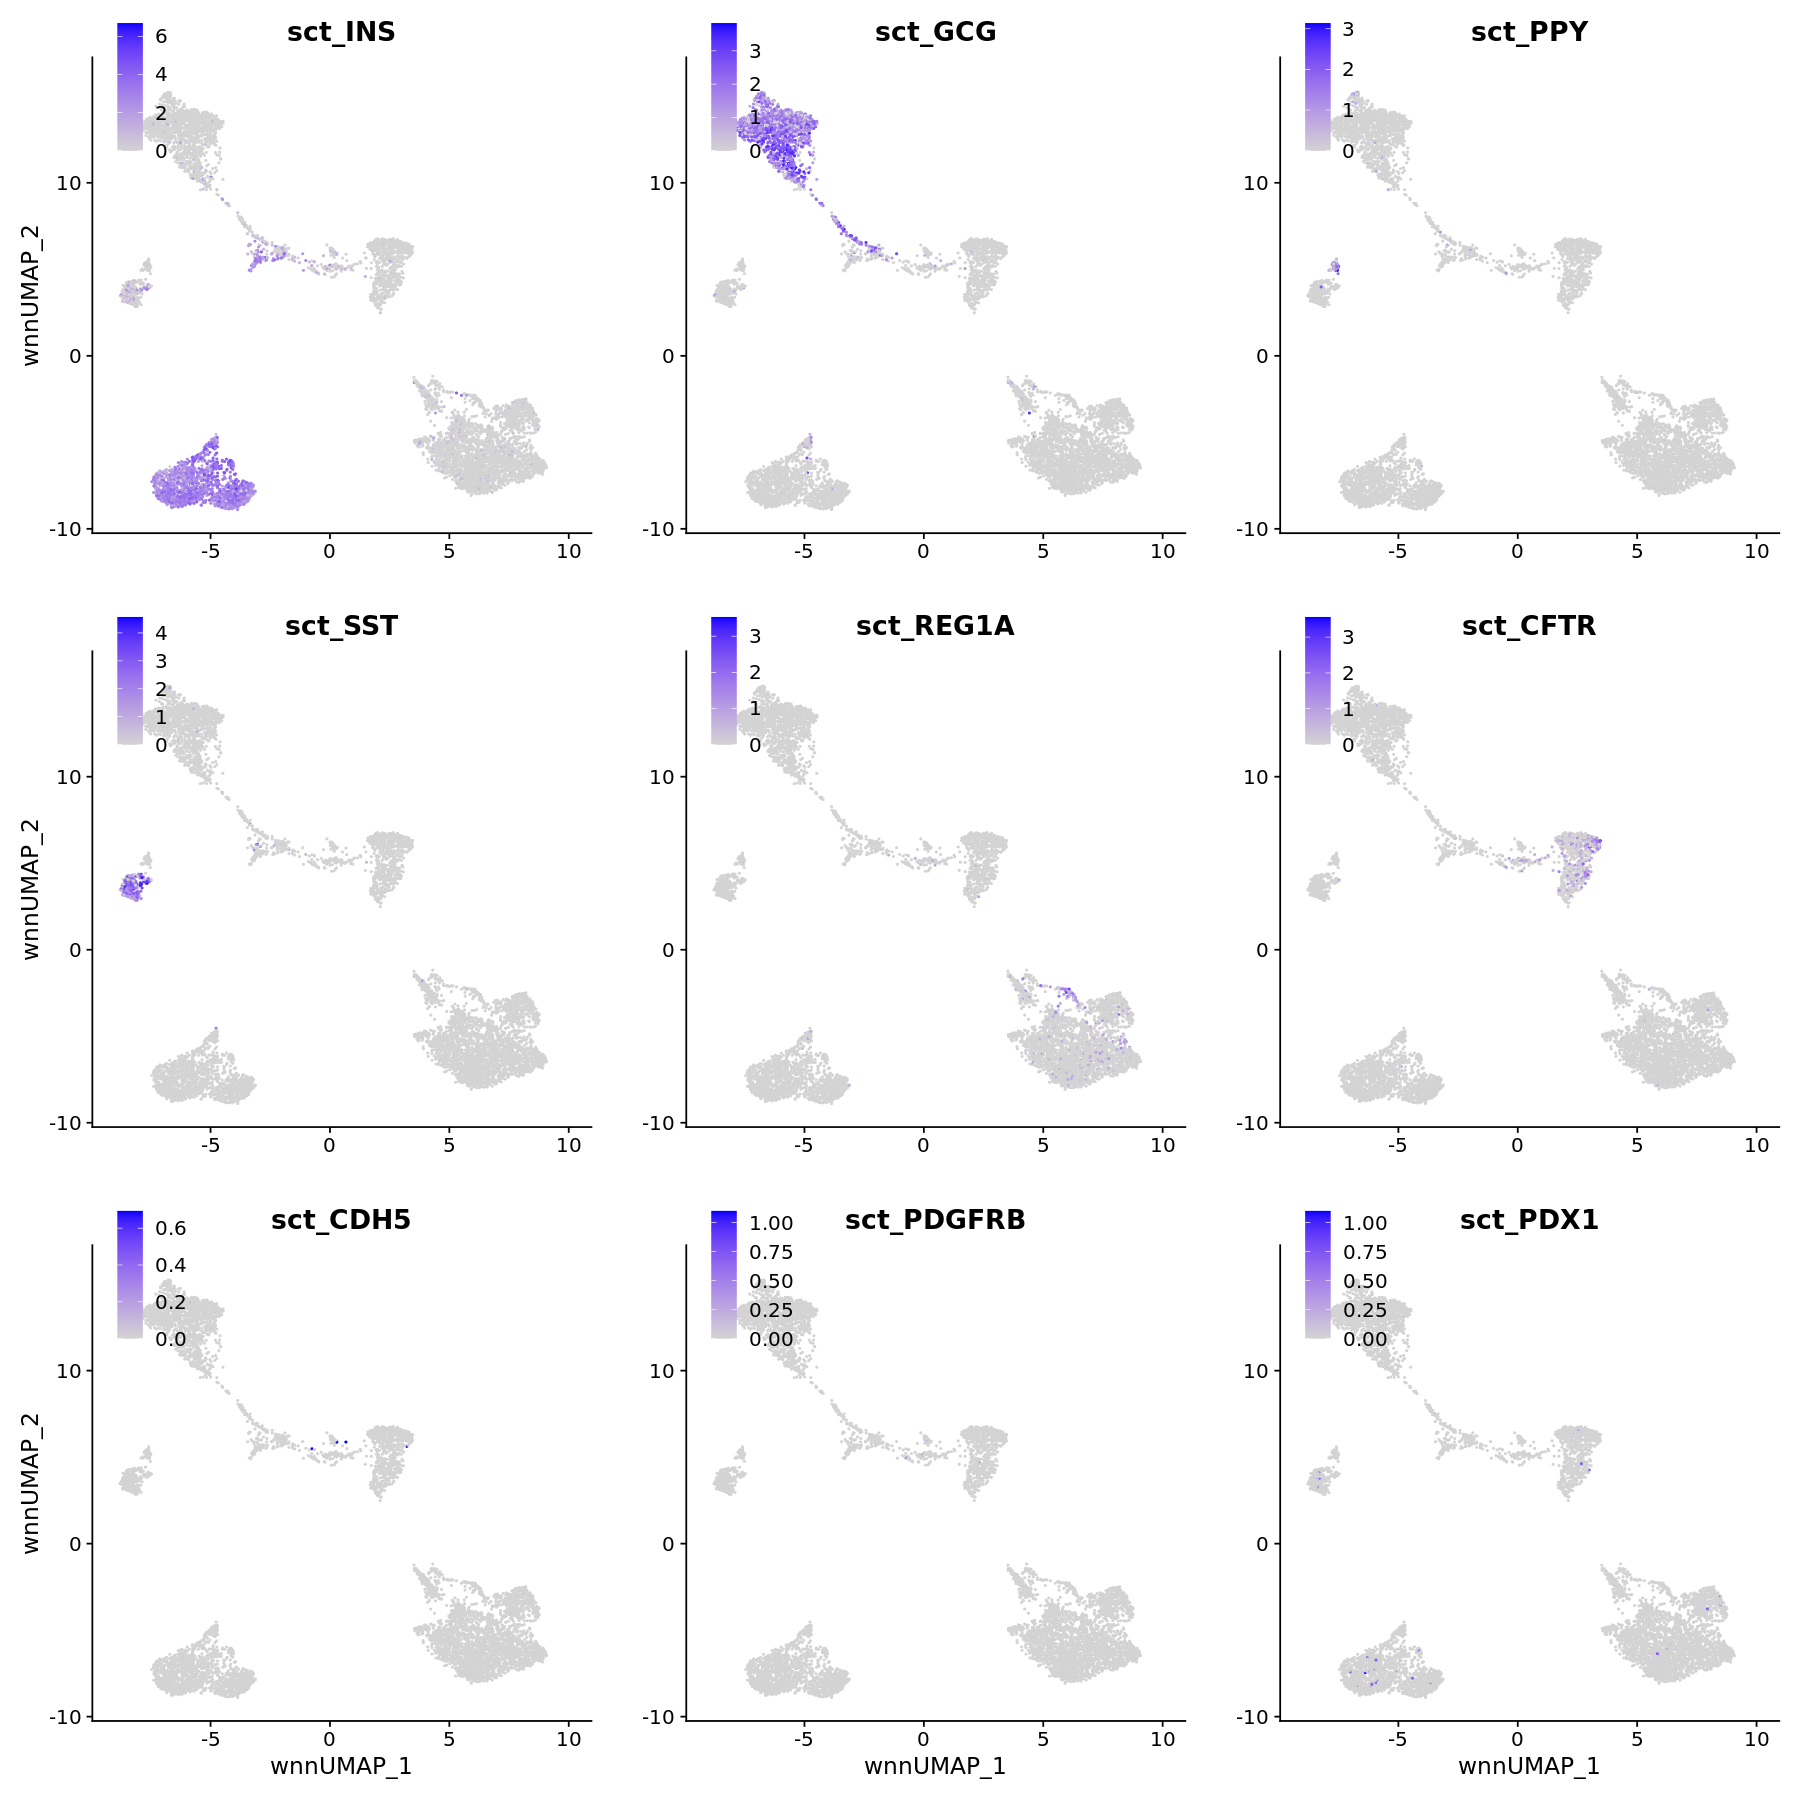

In [177]:
#read in marker genes short list from a file
#markers.fp2 <- '/nfs/lab/projects/multiomic_islet/references/islet_markers_shortlist.txt'
#marker.genes.short <- scan(markers.fp2,what="",sep="\n")
marker.genes.short

#select only for genes found in our data (only want 9)
gene_names <- row.names(adata2[["SCT"]][])
master_list <- marker.genes.short[marker.genes.short %in% gene_names]
master_list <- master_list[seq(1,9)]
#master_list

sct.master_list <- paste('sct_',master_list,sep="")
print("Marker genes selected for cell type FeaturePlots:")
print(sct.master_list)

#Plotting!
options(repr.plot.width=15, repr.plot.height=15)
p1 <- FeaturePlot(adata2, reduction='umap.wnn', features=sct.master_list[c(1,2,3)], ncol=3)
p2 <- FeaturePlot(adata2, reduction='umap.wnn', features=sct.master_list[c(4,5,6)], ncol=3) 
p3 <- FeaturePlot(adata2, reduction='umap.wnn', features=sct.master_list[c(7,8,9)], ncol=3) 

for (j in c(1,2,3)) {
    p1[[j]] <- p1[[j]] + xlab('')
    p2[[j]] <- p2[[j]] + xlab('')
}
for (j in c(2,3)) {
    p1[[j]] <- p1[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p2[[j]] <- p2[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p3[[j]] <- p3[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p1[[1]] <- p1[[1]] + theme(legend.position = c(.05, .95))
    p2[[1]] <- p2[[1]] + theme(legend.position = c(.05, .95))
    p3[[1]] <- p3[[1]] + theme(legend.position = c(.05, .95))
}
p1 / p2 / p3

[1] "INS"    "IAPP"   "HADH"   "GCG"    "FAP"    "TTR"    "SST"    "PPY"   
 [9] "CFTR"   "REG1A"  "CTRB2"  "PRSS1"  "PDGFRB" "COL6A1" "SPARC"  "RGS5"  
[17] "FABP4"  "GJC1"   "PLVAP"  "ESAM"   "VWF"    "CDH19"  "KIT"    "CD69"

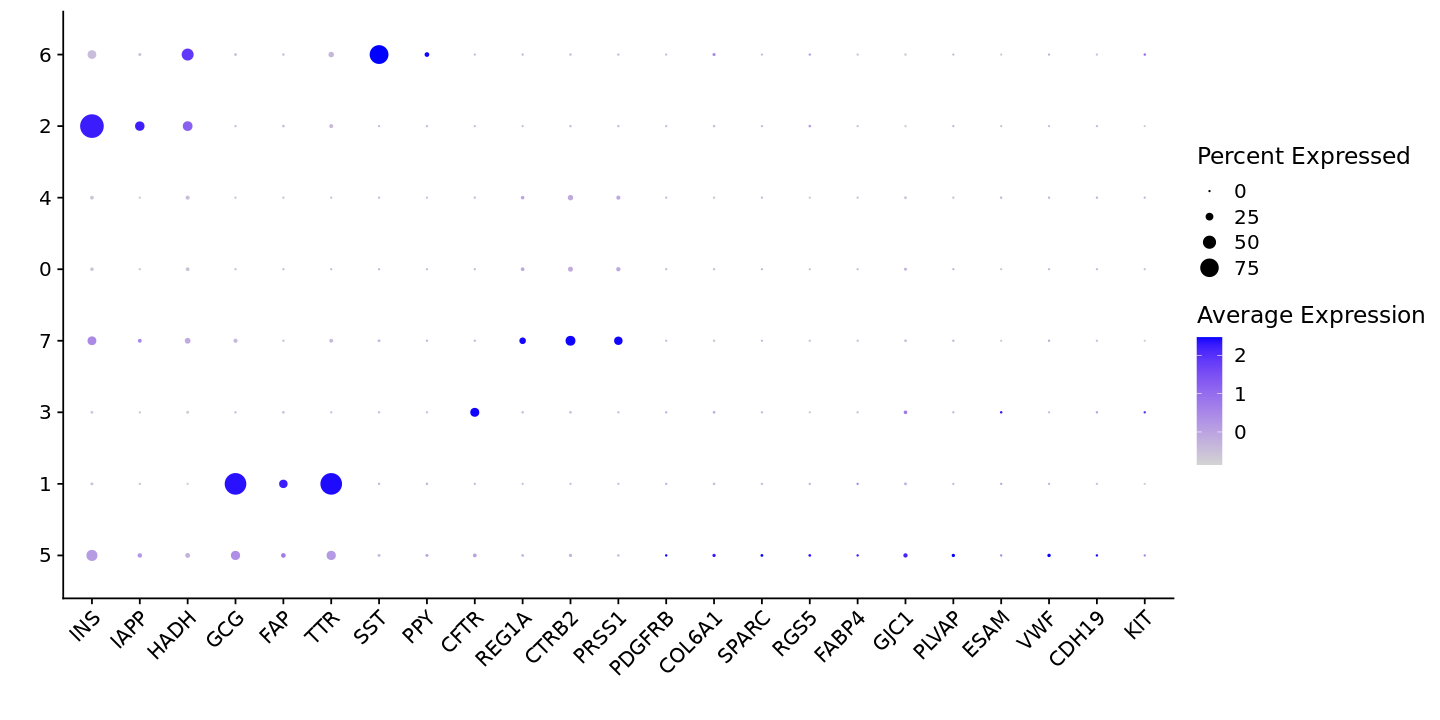

In [178]:
#read in marker genes list from a file
#markers.fp1 <- '/nfs/lab/projects/multiomic_islet/references/islet_markers.txt'
#marker.genes.long <- scan(markers.fp,what="",sep="\n")
marker.genes.long

options(repr.plot.width=12, repr.plot.height=6)
p1 <- DotPlot(adata2, assay='SCT', features=marker.genes.long, cluster.idents=TRUE) 
p1 <- p1 + theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
p1

In [89]:
save_dir <- "/nfs/lab/hmummey/multiomic_islet/intermediates/210818_filtering_test/"
saveRDS(adata2, file = file.path(save_dir,sprintf("%s_final_filtered.rds",sample)))